# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

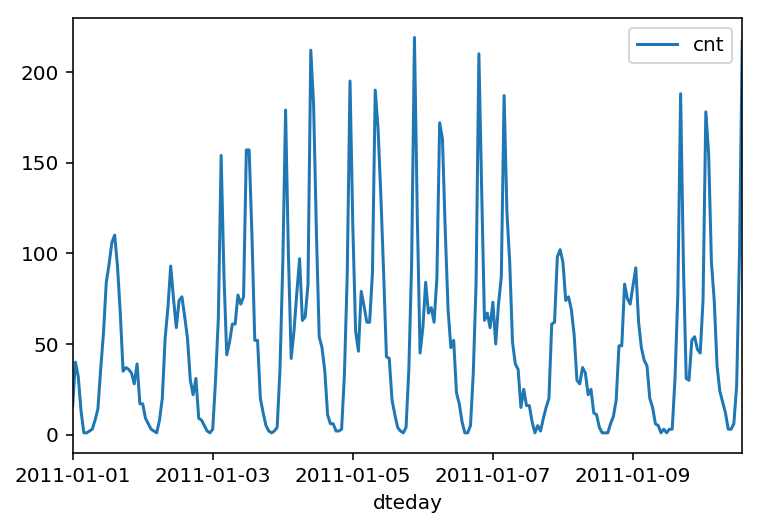

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        def sigmoid(x):
            return 1/(1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        
        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))
        
        self.activation_function = sigmoid
        self.activation_function_prime = sigmoid_prime
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets): # x = 3:1, y = 1:1
            print("X:")
            print(X)
            print("self.weights_input_to_hidden:")
            print(self.weights_input_to_hidden)
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer 1:2
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer 1:2
            
            print("hidden_inputs:")
            print(hidden_inputs)
            print("hidden_outputs:")
            print(hidden_outputs)


            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer 2:1 * 1*2
            #final_outputs = self.activation_function(final_inputs) # signals from final output layer 1:1
            final_outputs = final_inputs # f(x) = x
            
            print("final_inputs:") 
            print(final_inputs)
            print("final_outputs:") 
            print(final_outputs)
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            print("error:") 
            print(error)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            #output_error_term = error * self.activation_function_prime(final_inputs) # 1:1 x 1:1 = 1:1
            output_error_term = error * 1 # f'(x) = x' = 1
            
            print("output_error_term:") 
            print(output_error_term)
            
             # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(output_error_term, self.weights_hidden_to_output.T)
            
            print("hidden_error:") 
            print(hidden_error)
            
            hidden_error_term = hidden_error * self.activation_function_prime(hidden_inputs)
            
            print("hidden_error_term:") 
            print(hidden_error_term)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            print("delta_weights_i_h:") 
            print(delta_weights_i_h)
            
            #hidden_outputs = np.reshape(hidden_outputs,[2,1])
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None] # 1:1 * 1:2
            print("delta_weights_h_o:") 
            print(delta_weights_h_o)

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records  # update input-to-hidden weights with gradient descent step
        
        print("self.weights_hidden_to_output:") 
        print(self.weights_hidden_to_output)
            
        print("self.weights_input_to_hidden:") 
        print(self.weights_input_to_hidden)
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        # final_outputs = self.activation_function(final_inputs) # signals from final output layer 
        final_outputs = final_inputs
        
        print("run - final_outputs:")
        print(final_outputs)
        return final_outputs
    
print("reloaded2")

reloaded2


In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]]) 

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy() 

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)
# row : column

.....

run - final_outputs:
[[ 0.09998924]]
X:
[ 0.5 -0.2  0.1]
self.weights_input_to_hidden:
[[ 0.1 -0.2]
 [ 0.4  0.5]
 [-0.3  0.2]]
hidden_inputs:
[-0.06 -0.18]
hidden_outputs:
[ 0.4850045   0.45512111]
final_inputs:
[ 0.09998924]
final_outputs:
[ 0.09998924]
error:
[ 0.30001076]
output_error_term:
[ 0.30001076]
hidden_error:
[ 0.09000323 -0.03000108]
hidden_error_term:
[ 0.02248057 -0.00743984]
delta_weights_i_h:
[[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]
delta_weights_h_o:
[[ 0.14550657]
 [ 0.13654123]]
self.weights_hidden_to_output:
[[ 0.37275328]
 [-0.03172939]]
self.weights_input_to_hidden:
[[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.042s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [ ]:
import sys

print(sys.version_info)

### Set the hyperparameters here ###
iterations = 6000
learning_rate = 0.05
hidden_nodes = 20
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 epochs from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
X:
[ 0.          1.          0.8465731   0.7918483   0.03189788  0.          0.
  1.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342

/Users/Dylan/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


[ 1.          0.         -0.39981678  0.74001598 -0.45608552  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.06681983]
 [-0.41287

[[-1.02277897]
 [-1.22948859]
 [-1.06472167]
 [-1.09200252]
 [-0.87533285]
 [-1.17820209]
 [-0.93145128]
 [-1.08885881]
 [-0.77147328]
 [-0.67302735]
 [-0.8185324 ]
 [-0.76236861]
 [-0.81213254]
 [-1.03825871]
 [-1.00705685]
 [-0.87749716]
 [-0.96565682]
 [-0.73985501]
 [-0.8417567 ]
 [-0.92738196]]
X:
[ 1.          0.          1.98909715 -1.59243821  0.27629827  0.          0.
  1.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ...

[ 0.          0.         -0.71141425  0.94734524 -0.82146002  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  1.          0.          0.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.06681983]
 [-0.41287

 [ 0.82377461]]
X:
[ 1.          0.          0.74270727 -0.81495348  0.03189788  0.          1.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.0

self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.06681983]
 [-0.41287907 -0.03889647  0.07579491 ..., -0.13640069 -0.04784471
   0.1901584 ]
 [-0.08900371 -0.24039492  0.08008925 ..., -0.00470674 -0.15862423
  -0.02451447]]
hidden_inputs:
[ 0.07989579 -0.19214327  0.18875619 -0.01800714 -0.00770156  0.56932172
  0.0130081   0.33303708 -0.35694458 -0.07709892 -0.13010284  0.33348802
  0.11421832 -0.15042805  0.09383856  0.21357006  0.02506257 -0.33360561
  0.05178296 -0.21215409]
hidden_outputs:
[ 0.51996333  0.45211143  0.54704944  0.49549834  0.49807462  0.63860665
  0.50325198  0.58249816  0.4116994   0.48073481  0.46752009  0.58260782
  0.52852358  0.46246374  0.52344244  0.55319049

hidden_outputs:
[ 0.35347809  0.40722715  0.48891163  0.47792523  0.54019177  0.46496536
  0.31839986  0.29768312  0.50054     0.58756785  0.5588562   0.54791932
  0.5262588   0.45256004  0.57496442  0.57790086  0.42355102  0.50268001
  0.50951828  0.60153123]
final_inputs:
[-0.13500591]
final_outputs:
[-0.13500591]
error:
[-0.17627825]
output_error_term:
[-0.17627825]
hidden_error:
[ 0.02230825  0.07702505  0.01621247  0.01318887 -0.05776775 -0.03555133
 -0.00711049 -0.01568131  0.01972502  0.02284768  0.02651048  0.0018208
  0.02217994  0.01557921 -0.05589036  0.00104494  0.0825759  -0.01157828
 -0.05494664 -0.00411756]
hidden_error_term:
[ 0.00509813  0.01859332  0.00405112  0.00329079 -0.01434862 -0.0088442
 -0.00154313 -0.00327846  0.00493125  0.00553672  0.00653579  0.00045102
  0.00552969  0.00385974 -0.01365851  0.00025489  0.02016137 -0.00289449
 -0.01373168 -0.00098694]
delta_weights_i_h:
[[ -3.78747870e-01  -1.37798971e+00  -2.99822419e-01 ...,   2.06803245e-01
    9.7891991

final_inputs:
[-0.15846246]
final_outputs:
[-0.15846246]
error:
[ 0.15039638]
output_error_term:
[ 0.15039638]
hidden_error:
[-0.01903286 -0.06571592 -0.01383209 -0.01125243  0.04928606  0.03033154
  0.0060665   0.01337891 -0.01682891 -0.01949309 -0.02261811 -0.00155347
 -0.01892339 -0.0132918   0.04768432 -0.00089152 -0.07045178  0.00987831
  0.04687915  0.003513  ]
hidden_error_term:
[-0.00404255 -0.01642541 -0.00338798 -0.0027946   0.01178815  0.00751708
  0.00150455  0.00317623 -0.00392479 -0.00475161 -0.00550689 -0.00026888
 -0.00446913 -0.00332026  0.01179248 -0.00014941 -0.01755771  0.0023903
  0.01133818  0.0007824 ]
delta_weights_i_h:
[[ -4.00447568e-01  -1.45269561e+00  -3.18825078e-01 ...,   2.23700151e-01
    1.04288146e+00   7.46755896e-02]
 [ -4.75988433e-04   2.21691428e-03  -3.33778394e-04 ...,   6.37496229e-04
    1.29263162e-03  -1.91490097e-05]
 [ -6.17612989e-01  -2.10854959e+00  -4.61403109e-01 ...,   3.27007502e-01
    1.49331707e+00   1.12462542e-01]
 ..., 
 [  1

[ 1.          1.          0.8465731   0.32535746 -1.55384381  0.          0.
  1.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.06681983]
 [-0.41287

[ 1.56053357]
output_error_term:
[ 1.56053357]
hidden_error:
[-0.19748764 -0.68187747 -0.14352365 -0.11675676  0.51139898  0.31472429
  0.06294682  0.13882146 -0.1746191  -0.20226301 -0.23468858 -0.01611898
 -0.19635176 -0.13791759  0.49477904 -0.0092505  -0.73101739  0.1024987
  0.48642456  0.03645137]
hidden_error_term:
[-0.0460469  -0.1641966  -0.03292022 -0.02756741  0.12374523  0.07788256
  0.01568774  0.03398335 -0.04170106 -0.04920645 -0.05708539 -0.00402921
 -0.04908411 -0.03447277  0.12338677 -0.00228093 -0.18246768  0.0249698
  0.11730859  0.0090653 ]
delta_weights_i_h:
[[-0.37896158 -1.39418179 -0.30568011 ...,  0.21443426  1.00046096
   0.07123322]
 [ 0.02615227  0.08934559  0.01879174 ..., -0.01268269 -0.06219273
  -0.00495229]
 [-0.77132918 -2.67268866 -0.57623371 ...,  0.41096784  1.88385976
   0.14294161]
 ..., 
 [ 0.03604123  0.12262797  0.02673108 ..., -0.01905006 -0.09423628
  -0.00605393]
 [-0.11073467 -0.41515465 -0.0889405  ...,  0.06102072  0.29620053
   0.022417

 -0.58873493 -0.04464735]
hidden_outputs:
[ 0.43488924  0.45955514  0.52494581  0.55082799  0.31942444  0.48763965
  0.40179162  0.49751167  0.48505391  0.51066224  0.69622585  0.48261333
  0.50216942  0.56101605  0.54788784  0.61660527  0.5668387   0.31342186
  0.35692517  0.48884002]
final_inputs:
[-0.37697716]
final_outputs:
[-0.37697716]
error:
[-0.57933456]
output_error_term:
[-0.57933456]
hidden_error:
[ 0.07331557  0.2531411   0.05328191  0.04334494 -0.18985244 -0.11683867
 -0.02336846 -0.05153626  0.06482583  0.07508839  0.0871261   0.00598403
  0.07289389  0.05120071 -0.18368243  0.00343417  0.27138387 -0.03805176
 -0.1805809  -0.01353226]
hidden_error_term:
[ 0.01801808  0.06287119  0.01328732  0.01072425 -0.04127249 -0.02919182
 -0.00561673 -0.01288375  0.01619198  0.01876356  0.01842677  0.0014942
  0.01822313  0.01260956 -0.04549938  0.00081185  0.06663358 -0.0081883
 -0.04144866 -0.00338138]
delta_weights_i_h:
[[ -3.19874748e-01  -1.19980843e+00  -2.65466394e-01 ...,   1.

 [  6.50462191]]
X:
[ 1.          0.          0.22337816  0.74001598 -1.55384381  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.

[-0.34983694]
error:
[ 0.62293672]
output_error_term:
[ 0.62293672]
hidden_error:
[-0.07883349 -0.27219313 -0.05729204 -0.04660718  0.2041412   0.12563223
  0.02512723  0.05541501 -0.06970478 -0.08073973 -0.09368343 -0.0064344
 -0.07838006 -0.0550542   0.19750683 -0.00369263 -0.29180889  0.04091563
  0.19417187  0.01455073]
hidden_error_term:
[-0.0194929  -0.06706312 -0.01430661 -0.01164939  0.04993034  0.03084027
  0.00618961  0.01286538 -0.01710084 -0.0194316  -0.02318065 -0.00160837
 -0.0191522  -0.01361006  0.04933164 -0.00077718 -0.06677252  0.00969824
  0.04837288  0.00362479]
delta_weights_i_h:
[[-0.33982396 -1.28916563 -0.28076667 ...,  0.1917438   0.91824508
   0.06431421]
 [ 0.02615227  0.08934559  0.01879174 ..., -0.01268269 -0.06219273
  -0.00495229]
 [-1.07612214 -3.72670317 -0.80053176 ...,  0.56785804  2.64229015
   0.19988757]
 ..., 
 [-0.03165381 -0.11285278 -0.02253294 ...,  0.01616512  0.07473926
   0.00611269]
 [-0.12940775 -0.4905387  -0.10284919 ...,  0.06696921  

  0.213458   -0.00925878]
hidden_outputs:
[ 0.18078616  0.43140486  0.590094    0.38071635  0.64266593  0.42540378
  0.50624162  0.45570377  0.48955785  0.63057247  0.63059162  0.71347258
  0.61003472  0.48949359  0.52510062  0.64289105  0.30517131  0.37777907
  0.55316279  0.49768532]
final_inputs:
[-0.06692657]
final_outputs:
[-0.06692657]
error:
[ 1.61354229]
output_error_term:
[ 1.61354229]
hidden_error:
[-0.20419596 -0.70503971 -0.14839891 -0.12072279  0.52877035  0.32541495
  0.06508502  0.143537   -0.18055062 -0.20913354 -0.24266056 -0.01666652
 -0.2030215  -0.14260243  0.51158586 -0.00956473 -0.75584883  0.10598041
  0.50294759  0.03768956]
hidden_error_term:
[-0.03024194 -0.17294251 -0.03589518 -0.02846298  0.12143022  0.07954294
  0.01626872  0.03560261 -0.04511797 -0.04871783 -0.05652677 -0.00340713
 -0.04829726 -0.03563487  0.12757414 -0.00219589 -0.16027153  0.02491197
  0.12431543  0.00942219]
delta_weights_i_h:
[[-0.32823074 -1.30433771 -0.2813249  ...,  0.19201807  0.92

  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.13690244  0.08779697 -0.00105506 ..., -0.10161422  0.21331932
  -0.04931228]
 [ 0.17411192 -0.12861961 -0.08852859 ..., -0.23481717 -0.05766935
   0.10203163]
 [ 0.02855207 -0.04426687 -0.02725388 ...,  0.03284255  0.13662693
  -0.30756009]
 ..., 
 [-0.11634342 -0.0156075   0.0525978  ..., -0.00124898  0.06334237
   0.06681983]
 [-0.41287907 -0.03889647  0.07579491 ..., -0.13640069 -0.04784471
   0.1901584 ]
 [-0.08900371 -0.24039492  0.08008925 ..., -0.00470674 -0.15862423
  -0.02451447]]
hidden_inputs:
[ 0.25045769 -0.50300028  0.09408967 -0.20106819 -0.27923259  0.07655103
  0.30878474 -0.20545591 -0.40166581  0.26983966  0.64177147  0.60074627
 -0.1969953   0.02752848  0.25428467  0.37811076 -0.31624831 -0.02554471
 -0.02900631 -0.39874228]
hidden_outputs:
[ 0.56228915  0.37683585  0.52350508  0.44990162  0.43064193  0.51912842
  0.5765886   0.44881595  0.4009121

[ 1.41833624]
output_error_term:
[ 1.41833624]
hidden_error:
[-0.17695042 -0.61665364 -0.12679342 -0.10282934  0.46935125  0.28969807
  0.06157876  0.12844288 -0.15492786 -0.17921379 -0.20814644 -0.00650154
 -0.17429966 -0.12175103  0.45468052 -0.00217285 -0.65948679  0.09724453
  0.44726774  0.03710584]
hidden_error_term:
[-0.03909002 -0.13400936 -0.03148774 -0.02565309  0.11243222  0.07242451
  0.01536702  0.03168298 -0.03746087 -0.04467025 -0.05180946 -0.00131555
 -0.04355094 -0.03025628  0.1086522  -0.00052382 -0.16476361  0.02412997
  0.10350056  0.00901045]
delta_weights_i_h:
[[-0.03909002 -0.13400936 -0.03148774 ...,  0.02412997  0.10350056
   0.00901045]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.08461525 -0.29129528 -0.06766255 ...,  0.05184324  0.22603307
   0.01913401]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]


error:
[-0.81341535]
output_error_term:
[-0.81341535]
hidden_error:
[ 0.10148101  0.35365065  0.07271598  0.05897259 -0.26917278 -0.16614174
 -0.0353154  -0.07366195  0.08885107  0.10277905  0.11937191  0.00372863
  0.09996079  0.06982418 -0.26075912  0.00124613  0.37821545 -0.0557697
 -0.2565079  -0.02128019]
hidden_error_term:
[ 0.02394335  0.08780179  0.0181266   0.01446329 -0.06594088 -0.04097866
 -0.00882883 -0.01840769  0.02174065  0.0256892   0.0245      0.00093163
  0.02178455  0.01725998 -0.06517501  0.000308    0.08713215 -0.01379525
 -0.06230606 -0.00510589]
delta_weights_i_h:
[[-0.02174897 -0.05205263 -0.01373406 ...,  0.01249741  0.04140254
   0.00386743]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.18101606 -0.63443634 -0.14121407 ...,  0.10686719  0.4766914
   0.04003167]
 ..., 
 [ 0.02394335  0.08780179  0.0181266  ..., -0.01379525 -0.06230606
  -0.00510589]
 [ 0.          0.          0.         ...,  0.          0.          0.   

  0.58157795  0.42882873]
final_inputs:
[-0.09056381]
final_outputs:
[-0.09056381]
error:
[ 0.69444695]
output_error_term:
[ 0.69444695]
hidden_error:
[-0.08663861 -0.30192646 -0.0620807  -0.05034738  0.22980414  0.1418422
  0.03015024  0.06288831 -0.0758559  -0.0877468  -0.10191283 -0.00318329
 -0.08534074 -0.05961184  0.22262105 -0.00106387 -0.32289846  0.04761295
  0.2189916   0.01816779]
hidden_error_term:
[-0.0206743  -0.07316414 -0.01548569 -0.01247204  0.05578075  0.034346
  0.00739183  0.01571332 -0.01678896 -0.0215888  -0.02521019 -0.00064665
 -0.02123513 -0.01462343  0.05561936 -0.00024735 -0.07892175  0.01170248
  0.05329052  0.00444992]
delta_weights_i_h:
[[-0.10037694 -0.31225602 -0.07313911 ...,  0.05713098  0.25057885
   0.02112997]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.25359209 -0.87576141 -0.19538463 ...,  0.14736617  0.66394261
   0.05606319]
 ..., 
 [ 0.02394335  0.08780179  0.0181266  ..., -0.01379525 -0.06230606
  -0.0

[-0.23676793]
final_outputs:
[-0.23676793]
error:
[-0.62030879]
output_error_term:
[-0.62030879]
hidden_error:
[ 0.0773892   0.26969322  0.05545305  0.04497237 -0.20527058 -0.12669933
 -0.02693145 -0.05617444  0.06775764  0.07837908  0.09103276  0.00284345
  0.07622989  0.05324777 -0.19885434  0.0009503   0.28842628 -0.04252986
 -0.19561237 -0.01622823]
hidden_error_term:
[ 0.01920338  0.06697181  0.01380391  0.01108957 -0.04863324 -0.03161129
 -0.00646539 -0.01339661  0.01595813  0.0191398   0.02112073  0.0007037
  0.01894236  0.01290775 -0.04944945  0.0002243   0.0693414  -0.01062167
 -0.04797434 -0.00385343]
delta_weights_i_h:
[[-0.10647919 -0.35595089 -0.08091249 ...,  0.06318615  0.27755093
   0.02281021]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.25193734 -0.86104438 -0.1929919  ...,  0.14543625  0.65585717
   0.05551509]
 ..., 
 [-0.02782637 -0.09511701 -0.02260395 ...,  0.01710951  0.0813801
   0.00650838]
 [ 0.00346073  0.01373165  0.0

   1.05741991e-02  -1.70286164e-03  -7.91503138e-03  -6.73262109e-04]
delta_weights_i_h:
[[ -1.43846805e-01  -5.01651491e-01  -1.10941586e-01 ...,   8.67067497e-02
    3.86430475e-01   3.17457603e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -2.38648130e-01  -8.10658767e-01  -1.82014435e-01 ...,   1.36467101e-01
    6.17219980e-01   5.21343507e-02]
 ..., 
 [ -4.34979223e-02  -1.45904243e-01  -3.34772171e-02 ...,   2.56138599e-02
    1.21330363e-01   9.72917530e-03]
 [  2.58809307e-03  -6.99894187e-03  -1.12444050e-03 ...,   1.91012162e-03
    8.12762371e-03   4.91661309e-04]
 [ -4.54542780e-02  -1.40439938e-01  -3.60586695e-02 ...,   2.68421723e-02
    1.21222211e-01   1.12628243e-02]]
delta_weights_h_o:
[[ 2.91075857]
 [ 2.49056584]
 [ 3.38090034]
 [ 3.35246399]
 [ 4.21949783]
 [ 3.25381128]
 [ 2.65257189]
 [ 2.64674612]
 [ 2.96005506]
 [ 2.72393999]
 [ 3.27319718]
 [ 4.62466478]
 [ 3.39660179]
 [ 2.56215653]
 [

final_inputs:
[-0.24258488]
final_outputs:
[-0.24258488]
error:
[-0.79642268]
output_error_term:
[-0.79642268]
hidden_error:
[ 0.09936102  0.34626271  0.07119691  0.05774062 -0.26354963 -0.16267096
 -0.03457764 -0.07212311  0.08699493  0.10063194  0.11687817  0.00365074
  0.09787256  0.06836551 -0.25531173  0.0012201   0.37031433 -0.05460465
 -0.25114932 -0.02083563]
hidden_error_term:
[ 0.02452478  0.08607463  0.01594714  0.0143306  -0.06575397 -0.04066152
 -0.00860358 -0.01763409  0.02062507  0.02515564  0.02677584  0.00088169
  0.02435289  0.0169528  -0.06382619  0.00030274  0.09073098 -0.01196482
 -0.05704293 -0.00512099]
delta_weights_i_h:
[[ -1.99388718e-01  -6.84750637e-01  -1.53024518e-01 ...,   1.18198715e-01
    5.21091723e-01   4.42713939e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -3.22525662e-01  -1.09619238e+00  -2.43663993e-01 ...,   1.83428903e-01
    8.07748580e-01   7.08761419e-02]
 ..., 
 [ -

[[ -2.24213257e-01  -7.73068382e-01  -1.70592598e-01 ...,   1.31482050e-01
    5.80804686e-01   4.91496119e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -4.05801851e-01  -1.37910647e+00  -3.03332738e-01 ...,   2.30052942e-01
    1.01657836e+00   8.76195201e-02]
 ..., 
 [ -4.99589388e-02  -1.67933221e-01  -3.81454270e-02 ...,   2.92187272e-02
    1.37080981e-01   1.11168355e-02]
 [  2.58809307e-03  -6.99894187e-03  -1.12444050e-03 ...,   1.91012162e-03
    8.12762371e-03   4.91661309e-04]
 [ -6.09748647e-02  -1.99178592e-01  -5.02321869e-02 ...,   3.75735809e-02
    1.57797856e-01   1.50529982e-02]]
delta_weights_h_o:
[[ 2.85758831]
 [ 2.7423951 ]
 [ 3.31568787]
 [ 3.51946038]
 [ 4.83818662]
 [ 3.42322881]
 [ 3.08248308]
 [ 2.93210528]
 [ 3.17355641]
 [ 2.87850411]
 [ 3.45088503]
 [ 5.81068846]
 [ 4.12511536]
 [ 2.58581443]
 [ 4.10661776]
 [ 4.70787219]
 [ 4.41579823]
 [ 3.86167924]
 [ 4.80084055]
 [ 3.36548421]]


[ 0.          0.         -1.33460919  0.63635135 -0.69966852  1.          0.
  0.          0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.1370621   0.08717158 -0.00119084 ..., -0.10152106  0.21376228
  -0.04928019]
 [ 0.17412213 -0.12858471 -0.08852125 ..., -0.23482213 -0.05769364
   0.10202969]
 [ 0.02809127 -0.04586135 -0.02759682 ...,  0.03308604  0.13775063
  -0.30747414]
 ..., 
 [-0.11635603 -0.0156536   0.05258852 ..., -0.00124239  0.06337277
   0.06682245]
 [-0.41294

  0.19701254  0.01629893]
delta_weights_i_h:
[[-0.29813618 -1.01904867 -0.2214316  ...,  0.16551483  0.75724443
   0.06370464]
 [-0.07773409 -0.27060415 -0.05586304 ...,  0.03755086  0.19701254
   0.01629893]
 [-0.49851869 -1.72753064 -0.37382379 ...,  0.27944908  1.26023471
   0.10781688]
 ..., 
 [-0.04995894 -0.16793322 -0.03814543 ...,  0.02921873  0.13708098
   0.01111684]
 [ 0.02470283  0.09015902  0.01852345 ..., -0.01120458 -0.05930681
  -0.00540857]
 [-0.07979231 -0.26682471 -0.06433429 ...,  0.0483141   0.20722001
   0.01916666]]
delta_weights_h_o:
[[ 3.12791768]
 [ 2.71797487]
 [ 3.07325983]
 [ 3.61626322]
 [ 4.92083906]
 [ 3.43632984]
 [ 3.11503594]
 [ 3.11106331]
 [ 3.16121362]
 [ 2.6737731 ]
 [ 3.4753804 ]
 [ 6.29806764]
 [ 4.34760807]
 [ 2.29315988]
 [ 4.21689422]
 [ 5.15178643]
 [ 5.02919405]
 [ 3.75997426]
 [ 4.98858269]
 [ 2.94055593]]
X:
[ 0.          1.         -0.08821931 -1.54060589 -0.69966852  0.          0.
  0.          1.          1.          0.          0.   

hidden_error_term:
[-0.01190751 -0.04078311 -0.00848772 -0.00685358  0.03070364  0.02006713
  0.00374874  0.00881351 -0.0107008  -0.01237941 -0.01425993 -0.00043783
 -0.01191265 -0.00841358  0.03103142 -0.00014837 -0.0453063   0.00633649
  0.03085114  0.00249774]
delta_weights_i_h:
[[-0.29813618 -1.01904867 -0.2214316  ...,  0.16551483  0.75724443
   0.06370464]
 [-0.06198403 -0.21537631 -0.04346651 ...,  0.02782427  0.15265929
   0.01286143]
 [-0.51113477 -1.77031765 -0.38281655 ...,  0.28650654  1.29221051
   0.1102171 ]
 ..., 
 [-0.0100481  -0.03061269 -0.00865363 ...,  0.0063589   0.03138571
   0.00292771]
 [ 0.01279531  0.04937591  0.01003573 ..., -0.00486809 -0.02845567
  -0.00291083]
 [-0.07979231 -0.26682471 -0.06433429 ...,  0.0483141   0.20722001
   0.01916666]]
delta_weights_h_o:
[[ 2.55028122]
 [ 2.44581848]
 [ 2.62626383]
 [ 3.04827401]
 [ 4.50912665]
 [ 3.00220372]
 [ 2.77102131]
 [ 2.83116641]
 [ 2.70547942]
 [ 2.29688394]
 [ 2.97146182]
 [ 5.80256059]
 [ 3.97601945]
 [ 

[-0.22121342]
final_outputs:
[-0.22121342]
error:
[-0.76266358]
output_error_term:
[-0.76266358]
hidden_error:
[ 0.09514926  0.33158518  0.06817898  0.05529309 -0.25237817 -0.15577559
 -0.03311195 -0.06906593  0.08330735  0.09636631  0.11192389  0.00349599
  0.0937239   0.06546761 -0.24448947  0.00116838  0.35461729 -0.05229004
 -0.24050349 -0.01995244]
hidden_error_term:
[ 0.02249566  0.08246819  0.01704242  0.01332842 -0.06266739 -0.03845205
 -0.00827604 -0.01724144  0.02063511  0.02373916  0.02797816  0.00086161
  0.02260777  0.01622252 -0.05972665  0.00028136  0.08777188 -0.01197742
 -0.05922023 -0.0045787 ]
delta_weights_i_h:
[[-0.33319625 -1.13027355 -0.24640699 ...,  0.18604333  0.84606713
   0.07099468]
 [-0.06198403 -0.21537631 -0.04346651 ...,  0.02782427  0.15265929
   0.01286143]
 [-0.52003566 -1.78391597 -0.38735255 ...,  0.29036428  1.30761514
   0.11206388]
 ..., 
 [-0.0100481  -0.03061269 -0.00865363 ...,  0.0063589   0.03138571
   0.00292771]
 [ 0.01279531  0.04937591 

   0.01916666]]
delta_weights_h_o:
[[  6.14222488]
 [  6.65238466]
 [  6.76774625]
 [  7.52787708]
 [  9.19267624]
 [  7.16432096]
 [  7.15425575]
 [  6.18652561]
 [  7.04083036]
 [  7.11581668]
 [  7.88871228]
 [ 12.67523909]
 [  8.88757833]
 [  5.998548  ]
 [  8.49639216]
 [ 10.05803089]
 [  9.45737172]
 [  7.36401277]
 [  9.93801858]
 [  6.58911894]]
X:
[ 0.          0.          0.22337816  1.31017145  0.51988127  0.          1.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.        ]
self.weights_inp

final_inputs:
[-0.2040986]
final_outputs:
[-0.2040986]
error:
[-0.65297811]
output_error_term:
[-0.65297811]
hidden_error:
[ 0.08146499  0.28389695  0.05837355  0.0473409  -0.21608141 -0.13337211
 -0.02834982 -0.05913294  0.07132617  0.08250701  0.09582712  0.0029932
  0.08024463  0.05605212 -0.20932725  0.00100034  0.30361661 -0.04476974
 -0.20591454 -0.0170829 ]
hidden_error_term:
[ 0.02026142  0.06591098  0.01457494  0.01168717 -0.05067296 -0.03326112
 -0.00708672 -0.01476867  0.01734248  0.02034511  0.02392651  0.0007461
  0.01850798  0.01396115 -0.05210869  0.00024209  0.07337339 -0.01119199
 -0.05101855 -0.00416786]
delta_weights_i_h:
[[-0.6093572  -2.11973256 -0.44869392 ...,  0.33846588  1.55510146
   0.13003384]
 [-0.06198403 -0.21537631 -0.04346651 ...,  0.02782427  0.15265929
   0.01286143]
 [-0.86077868 -3.00141566 -0.63607802 ...,  0.47650371  2.17569518  0.18443   ]
 ..., 
 [-0.04491081 -0.15542522 -0.03370218 ...,  0.02610671  0.11616032
   0.01039014]
 [-0.10240495 -0.3

 [  7.40993586]]
X:
[ 0.          0.         -0.71141425  0.42902209 -1.55384381  1.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.1370621   0.08717158 -0.00119084 ..., -0.10152106  0.21376228
  -0.04928019]
 [ 0.17412213 -0.12858471 -0.08852125 ..., -0.23482213 -0.05769364
   0.10202969]
 [ 0.02809127 -0.04586135 -0.02759682 ...,  0.03308604  0.13775063
  -0.30747414]
 ..., 
 [-0.11635603 -0.0156536   0.05258852 ..., -0.00124239  0.06337277
   0.

[-0.29311814]
final_outputs:
[-0.29311814]
error:
[ 0.44493068]
output_error_term:
[ 0.44493068]
hidden_error:
[-0.05550917 -0.19344364 -0.03977497 -0.03225746  0.14723503  0.090878
  0.0193172   0.0402924  -0.04860072 -0.05621919 -0.06529533 -0.00203953
 -0.05467763 -0.03819318  0.14263283 -0.00068162 -0.20688036  0.03050551
  0.14030745  0.01164007]
hidden_error_term:
[-0.01240905 -0.0471992  -0.00992019 -0.00790582  0.03680505  0.02267718
  0.00482263  0.00840185 -0.01193298 -0.01302504 -0.01551531 -0.00046934
 -0.01366939 -0.00911912  0.0352185  -0.00012219 -0.05095579  0.00700135
  0.03424502  0.00278718]
delta_weights_i_h:
[[-0.78807791 -2.75611091 -0.57991927 ...,  0.438516    1.99604372
   0.16605898]
 [-0.06198403 -0.21537631 -0.04346651 ...,  0.02782427  0.15265929
   0.01286143]
 [-0.91549617 -3.19577271 -0.67859161 ...,  0.50867007  2.30249413
   0.19795077]
 ..., 
 [-0.09805924 -0.33768917 -0.07191905 ...,  0.05544372  0.23134275
   0.02156081]
 [-0.11180785 -0.38977041 -0

 [  8.76030485]]
X:
[ 0.          0.         -0.5036826   0.68818367  1.13047356  0.          0.
  0.          1.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.1370621   0.08717158 -0.00119084 ..., -0.10152106  0.21376228
  -0.04928019]
 [ 0.17412213 -0.12858471 -0.08852125 ..., -0.23482213 -0.05769364
   0.10202969]
 [ 0.02809127 -0.04586135 -0.02759682 ...,  0.03308604  0.13775063
  -0.30747414]
 ..., 
 [-0.11635603 -0.0156536   0.05258852 ..., -0.00124239  0.06337277
   0.

final_outputs:
[-0.16427459]
error:
[-0.36201876]
output_error_term:
[-0.36201876]
hidden_error:
[ 0.04516515  0.15739581  0.03236299  0.02624635 -0.11979808 -0.07394307
 -0.01571748 -0.032784    0.03954407  0.04574286  0.05312768  0.00165947
  0.04448857  0.03107596 -0.1160535   0.0005546   0.16832862 -0.02482087
 -0.11416144 -0.00947096]
hidden_error_term:
[ 0.00925887  0.03907005  0.00790804  0.0064219  -0.02981668 -0.01844256
 -0.00391785 -0.00805286  0.00946598  0.0114293   0.01312002  0.00039066
  0.01105566  0.00775743 -0.02803922  0.00013708  0.04173217 -0.00620121
 -0.02853366 -0.00236708]
delta_weights_i_h:
[[-0.82340669 -2.86219479 -0.59873794 ...,  0.45687214  2.08030293
   0.17298391]
 [-0.06198403 -0.21537631 -0.04346651 ...,  0.02782427  0.15265929
   0.01286143]
 [-1.09361439 -3.8344801  -0.80843916 ...,  0.606295    2.75529184
   0.23602989]
 ..., 
 [-0.09805924 -0.33768917 -0.07191905 ...,  0.05544372  0.23134275
   0.02156081]
 [-0.10287877 -0.34341154 -0.07008888 ..

[ 1.          0.          0.22337816 -0.71128885  1.61845695  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.1370621   0.08717158 -0.00119084 ..., -0.10152106  0.21376228
  -0.04928019]
 [ 0.17412213 -0.12858471 -0.08852125 ..., -0.23482213 -0.05769364
   0.10202969]
 [ 0.02809127 -0.04586135 -0.02759682 ...,  0.03308604  0.13775063
  -0.30747414]
 ..., 
 [-0.11635603 -0.0156536   0.05258852 ..., -0.00124239  0.06337277
   0.06682245]
 [-0.41294

[[  8.61023047]
 [  9.10466476]
 [  9.06837941]
 [ 10.26217886]
 [ 12.85175441]
 [ 10.16010984]
 [  9.59412939]
 [  7.61720151]
 [ 10.12963131]
 [  9.64602676]
 [ 11.03343547]
 [ 18.08202609]
 [ 12.079917  ]
 [  8.59368953]
 [ 11.82392911]
 [ 13.76890414]
 [ 12.60212676]
 [ 10.1321507 ]
 [ 13.35419508]
 [  9.51202078]]
X:
[ 1.          0.         -0.5036826   1.93215924 -0.45608552  1.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.1370621   0.0871

   0.02427314]]
delta_weights_h_o:
[[  7.68066648]
 [  8.0763177 ]
 [  7.88344027]
 [  9.09048671]
 [ 11.64526775]
 [  9.08743502]
 [  8.57094774]
 [  6.7193414 ]
 [  9.13080906]
 [  8.52572456]
 [  9.81870309]
 [ 16.89929321]
 [ 10.89818819]
 [  7.49312501]
 [ 10.58771855]
 [ 12.55967219]
 [ 11.62940295]
 [  9.07802887]
 [ 12.15226928]
 [  8.25432908]]
X:
[ 0.          0.         -0.71141425  1.25833914 -0.82146002  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.          0.        ]
self.weights_inp

 -0.15984418 -0.01326086]
hidden_error_term:
[ 0.01473375  0.05484325  0.01132577  0.00874629 -0.04104386 -0.02586668
 -0.00538762 -0.01123739  0.01223884  0.01600111  0.01847812  0.0005794
  0.01406768  0.01085888 -0.0397278   0.00018702  0.05818821 -0.00867734
 -0.0397217  -0.00326583]
delta_weights_i_h:
[[-0.86523843 -2.96492604 -0.62841023 ...,  0.47928488  2.18410511
   0.18073657]
 [-0.03623707 -0.12704287 -0.02493039 ...,  0.01368204  0.08746193
   0.00765223]
 [-1.13214226 -3.9572378  -0.8380661  ...,  0.629778    2.86340562
   0.24441533]
 ..., 
 [-0.07614994 -0.26001075 -0.05610213 ...,  0.04366875  0.17925039
   0.01749843]
 [-0.09134709 -0.30253486 -0.06073742 ...,  0.04825107  0.2104015
   0.01679239]
 [-0.10388356 -0.31686481 -0.08311233 ...,  0.0625579   0.27108223
   0.02427314]]
delta_weights_h_o:
[[  5.89884235]
 [  6.7726904 ]
 [  6.30810716]
 [  7.37821076]
 [ 10.24845638]
 [  7.50417838]
 [  7.08738461]
 [  5.25943233]
 [  7.95480507]
 [  7.10548751]
 [  8.26790351

  -0.02450326]]
hidden_inputs:
[-1.13938793  0.14464708 -0.12369722 -0.20837763 -0.03917462 -0.35208491
  0.28089968 -0.27372579 -0.27664932  0.2158256   0.35570584  1.37998312
  0.35525797 -0.16322571  0.13109384  1.05928044 -0.00139708 -0.77734592
  0.09022516 -0.53811707]
hidden_outputs:
[ 0.24243276  0.53609885  0.46911507  0.44809328  0.4902076   0.41287693
  0.56976678  0.43199265  0.43127543  0.55374793  0.58800054  0.79898829
  0.58789204  0.45928393  0.53272661  0.74255301  0.49965073  0.31489218
  0.522541    0.36862571]
final_inputs:
[-0.21271519]
final_outputs:
[-0.21271519]
error:
[ 0.90480722]
output_error_term:
[ 0.90480722]
hidden_error:
[-0.11288298 -0.39338533 -0.08088604 -0.0655985   0.29941589  0.18480872
  0.03928329  0.08193829 -0.098834   -0.11432686 -0.13278403 -0.00414756
 -0.11119196 -0.07766932  0.2900569  -0.00138614 -0.42071012  0.06203575
  0.28532803  0.02367114]
hidden_error_term:
[-0.02073199 -0.0978337  -0.02014435 -0.01622288  0.07482526  0.0447994
  

hidden_outputs:
[ 0.55914949  0.50297525  0.62133307  0.60999381  0.49228411  0.51575359
  0.60179706  0.57344931  0.40471006  0.4673751   0.61907321  0.45510185
  0.52098639  0.5745599   0.61141117  0.46548509  0.45804819  0.54121785
  0.57288267  0.57683788]
final_inputs:
[-0.13628129]
final_outputs:
[-0.13628129]
error:
[-0.63809958]
output_error_term:
[-0.63809958]
hidden_error:
[ 0.07960876  0.27742817  0.05704347  0.0462622  -0.21115785 -0.13033314
 -0.02770386 -0.05778556  0.06970096  0.08062703  0.09364363  0.002925
  0.0784162   0.05477494 -0.2045576   0.00097755  0.29669851 -0.04374964
 -0.20122264 -0.01669366]
hidden_error_term:
[ 0.01962367  0.06935459  0.01342109  0.01100584 -0.05277689 -0.03255094
 -0.00663888 -0.01413465  0.01679234  0.02007094  0.02208319  0.00072535
  0.01956951  0.01338923 -0.04860034  0.00024322  0.07365245 -0.01086308
 -0.04923679 -0.00407485]
delta_weights_i_h:
[[-0.9604804  -3.33304989 -0.70302236 ...,  0.53428365  2.44572258
   0.20202362]
 [-0.0

[[-1.05150587 -3.64251165 -0.77010274 ...,  0.58755006  2.68128349
   0.22213421]
 [-0.03623707 -0.12704287 -0.02493039 ...,  0.01368204  0.08746193
   0.00765223]
 [-1.32689318 -4.65266247 -0.98655308 ...,  0.74312898  3.38888492
   0.2879015 ]
 ..., 
 [-0.15056882 -0.51998514 -0.11224857 ...,  0.08853004  0.38212861
   0.03463245]
 [-0.07994699 -0.28144944 -0.05625092 ...,  0.04318779  0.19370921
   0.01509331]
 [-0.10617654 -0.31711959 -0.08542223 ...,  0.06452951  0.27958874
   0.02468073]]
delta_weights_h_o:
[[  8.48359041]
 [  9.56931092]
 [  9.27864746]
 [ 10.48349768]
 [ 14.09756575]
 [ 10.72803366]
 [ 10.71022791]
 [  8.24003494]
 [ 11.03150237]
 [ 10.03240267]
 [ 11.91111997]
 [ 20.39022466]
 [ 13.14699737]
 [  8.90463132]
 [ 12.82014512]
 [ 15.1710593 ]
 [ 13.50176839]
 [ 10.84927003]
 [ 14.45564732]
 [  9.84065084]]
X:
[ 0.          0.         -0.19208513 -0.81495348 -0.45608552  0.          0.
  0.          1.          0.          1.          0.          0.          0.
  0

Progress: 0.0% ... Training loss: 0.939 ... Validation loss: 1.405X:
[ 0.          0.         -1.23074336 -0.14113338  0.03189788  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.13746294  0.08578316 -0.00148464 ..., -0.10129693  0.21478586
  -0.04919546]
 [ 0.17410798 -0.12863433 -0.08853099 ..., -0.23481678 -0.05765947
   0.10203268]
 [ 0.02757608 -0.04767009 -0.02797992 ...,  0.03337447  0.13906577
  -0.30736237]
 ..., 
 [-0.11641485 -0.015856

[ 0.10284494  0.05725273  0.14363091  0.51960558 -0.11987462 -0.30107341
 -0.33406048  0.57392614  0.07469681 -0.24155656 -0.32490754 -0.38786974
  0.735993    0.02215641 -0.38430234 -0.72386915 -0.21976392  0.35738934
  0.14853397  0.31712195]
hidden_outputs:
[ 0.5256886   0.51430927  0.53584612  0.62705553  0.47006718  0.4252951
  0.41725298  0.63966862  0.51866552  0.4399028   0.41948021  0.40423022
  0.67611902  0.50553888  0.40508965  0.32654154  0.44527908  0.58840832
  0.53706537  0.57862269]
final_inputs:
[-0.17630988]
final_outputs:
[-0.17630988]
error:
[-0.58153183]
output_error_term:
[-0.58153183]
hidden_error:
[ 0.07072832  0.25075694  0.04999546  0.0398988  -0.19554486 -0.12108713
 -0.02752798 -0.05439648  0.06110936  0.07129525  0.08275168 -0.00181879
  0.06860496  0.04801446 -0.18921537 -0.00241492  0.26744102 -0.04223074
 -0.18653333 -0.01735222]
hidden_error_term:
[ 0.01763541  0.06263789  0.01243462  0.00933061 -0.04871101 -0.02959602
 -0.00669351 -0.01253799  0.01525

self.weights_input_to_hidden:
[[-0.13746294  0.08578316 -0.00148464 ..., -0.10129693  0.21478586
  -0.04919546]
 [ 0.17410798 -0.12863433 -0.08853099 ..., -0.23481678 -0.05765947
   0.10203268]
 [ 0.02757608 -0.04767009 -0.02797992 ...,  0.03337447  0.13906577
  -0.30736237]
 ..., 
 [-0.11641485 -0.01585672  0.05254467 ..., -0.0012078   0.06352204
   0.06683597]
 [-0.41297172 -0.03925894  0.07572027 ..., -0.13634908 -0.04759132
   0.19017739]
 [-0.08910072 -0.24071857  0.08001148 ..., -0.00464995 -0.15836901
  -0.02449412]]
hidden_inputs:
[-0.34329563 -0.70779537  0.16456747 -0.29192085 -0.29235564  0.03974591
  0.01816594 -0.12824181 -0.65376449  0.24936042  0.88221176  0.4028593
 -0.01389426  0.03500864  0.34485781  0.3178284  -0.11357696 -0.14360997
 -0.15461787 -0.13419998]
hidden_outputs:
[ 0.41500915  0.33008617  0.54104927  0.42753368  0.42742727  0.50993517
  0.50454136  0.46798341  0.34214172  0.56201907  0.70728034  0.59937444
  0.49652649  0.50875127  0.58537006  0.57879493 

hidden_error_term:
[-0.02502934 -0.09124009 -0.01805139 -0.01456717  0.0674618   0.04384484
  0.00994591  0.01992467 -0.02107264 -0.02481427 -0.03007713  0.00062492
 -0.02450604 -0.01503983  0.06785571  0.00085501 -0.08342571  0.01484626
  0.0672445   0.00635589]
delta_weights_i_h:
[[-0.02548888 -0.09253336 -0.01831609 ...,  0.01505124  0.06210577
   0.0054609 ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.34363749 -1.17358361 -0.24449879 ...,  0.20543632  0.88837444
   0.07771295]
 ..., 
 [-0.03214176 -0.10387825 -0.02269982 ...,  0.01927555  0.08377261
   0.00661154]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.01822869 -0.03978407 -0.01222866 ...,  0.01075552  0.04593784
   0.00287474]]
delta_weights_h_o:
[[ 0.64389786]
 [ 0.46051175]
 [ 0.9649697 ]
 [ 0.24643586]
 [ 0.82209516]
 [ 0.96544686]
 [ 1.38578723]
 [ 0.53234558]
 [ 0.51804712]
 [ 1.05968444]
 [ 0.9782331 ]
 [ 2.18971263]
 [ 0.64503282]
 [ 0.28

hidden_inputs:
[ 0.40720021 -0.38068595  0.01865675  0.17557254 -0.49378543  0.37843428
  0.30363086 -0.14727911 -0.43717847 -0.10370117  0.14443682  0.42559787
 -0.35986137 -0.16865044  0.11595319  0.35156068  0.18579517 -0.32548713
  0.05103706 -0.59968237]
hidden_outputs:
[ 0.60041635  0.40596147  0.50466405  0.54378073  0.37900222  0.59349542
  0.57532987  0.46324663  0.39241349  0.47409792  0.53604656  0.60482199
  0.41099312  0.45793704  0.52895586  0.58699599  0.54631563  0.41933908
  0.5127565   0.35441637]
final_inputs:
[-0.13842664]
final_outputs:
[-0.13842664]
error:
[-0.8399373]
output_error_term:
[-0.8399373]
hidden_error:
[ 0.10215666  0.36218156  0.0722111   0.05762796 -0.28243582 -0.17489257
 -0.03976013 -0.07856772  0.0882635   0.10297552  0.11952264 -0.00262698
  0.09908979  0.06934984 -0.27329381 -0.003488    0.38627927 -0.06099611
 -0.26941999 -0.02506273]
hidden_error_term:
[ 0.02450908  0.08734253  0.0180512   0.01429653 -0.06647396 -0.04219434
 -0.00971441 -0.019

  0.          0.          1.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13746294  0.08578316 -0.00148464 ..., -0.10129693  0.21478586
  -0.04919546]
 [ 0.17410798 -0.12863433 -0.08853099 ..., -0.23481678 -0.05765947
   0.10203268]
 [ 0.02757608 -0.04767009 -0.02797992 ...,  0.03337447  0.13906577
  -0.30736237]
 ..., 
 [-0.11641485 -0.01585672  0.05254467 ..., -0.0012078   0.06352204
   0.06683597]
 [-0.41297172 -0.03925894  0.07572027 ..., -0.13634908 -0.04759132
   0.19017739]
 [-0.08910072 -0.24071857  0.08001148 ..., -0.00464995 -0.15836901
  -0.02449412]]
hidden_inputs:
[-0.37237116  0.3932312   0.49367718  0.05536104  0.43797611  0.16229456
 -0.1392329  -0.03630142  0.03491696  0.2215023   0.5883743  -0.17630099
  0.11806565 -0.02011076  0.11635133  0.83937727 -0.02647031 -0.67615344
 -0.13641062  0.08600712]
hidden_outputs:
[ 0.40796819  0.5970603   0.6209723   0.51383673  0.60777667  0.54048482
  0.4652479   0.49092564  0.5087283

output_error_term:
[ 1.78957254]
hidden_error:
[-0.21765525 -0.77166495 -0.15385315 -0.12278228  0.60175847  0.37262655
  0.08471303  0.16739659 -0.18805444 -0.2193999  -0.25465525  0.00559705
 -0.21112096 -0.14775694  0.58228047  0.00743154 -0.82300758  0.12995846
  0.57402692  0.05339872]
hidden_error_term:
[-0.05378236 -0.19156126 -0.0365384  -0.0298884   0.14105499  0.09164194
  0.0208131   0.04120796 -0.04320472 -0.0538319  -0.06358741  0.00139926
 -0.04468115 -0.03680013  0.14388316  0.00180071 -0.20534623  0.0316124
  0.14297763  0.01308295]
delta_weights_i_h:
[[ -4.30009958e-02  -2.11898767e-01  -3.85332659e-02 ...,   3.31765720e-02
    1.12171345e-01   1.18400406e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -5.10475314e-01  -1.77811726e+00  -3.68880704e-01 ...,   3.11633450e-01
    1.31902676e+00   1.20527483e-01]
 ..., 
 [ -3.21080457e-03  -2.58917303e-03  -3.20608759e-03 ...,   1.92665169e-03
    7.63

  0.32910927  0.07811885]
hidden_outputs:
[ 0.6127656   0.62426652  0.45866657  0.67653523  0.31287545  0.48327673
  0.45813889  0.40432767  0.50408085  0.59594585  0.480039    0.41948067
  0.50902135  0.48788074  0.57781871  0.47675698  0.54964479  0.49151368
  0.58154263  0.51951979]
final_inputs:
[-0.28263793]
final_outputs:
[-0.28263793]
error:
[-0.41456016]
output_error_term:
[-0.41456016]
hidden_error:
[ 0.05042053  0.17875863  0.03564057  0.02844291 -0.13939926 -0.08632012
 -0.01962404 -0.03877795  0.04356341  0.05082468  0.0589917  -0.00129657
  0.04890684  0.03422836 -0.13488712 -0.00172154  0.19065232 -0.03010529
 -0.13297516 -0.01236998]
hidden_error_term:
[ 0.01196398  0.04192924  0.00884925  0.00622431 -0.02996867 -0.02155589
 -0.00487162 -0.00933955  0.01089013  0.0122383   0.01472442 -0.00031574
  0.01222273  0.00855206 -0.03290494 -0.00042945  0.0471932  -0.00752415
 -0.03235961 -0.00308778]
delta_weights_i_h:
[[ -6.58262114e-02  -2.95076049e-01  -5.50821131e-02 ...,   

  -0.02449412]]
hidden_inputs:
[-0.78885659 -0.18006727  0.11099338 -0.35137838  0.64289439 -0.11888626
 -0.96666948 -0.7701501   0.13412897  0.34771435  1.11565384  0.08127309
 -0.09942184  0.11354881  0.23461108  0.20917861 -0.76609404 -0.55462067
 -0.83744885  0.50143815]
hidden_outputs:
[ 0.31241423  0.45510443  0.52771989  0.41304821  0.65540745  0.47031339
  0.27554484  0.31644664  0.53348206  0.5860632   0.75318166  0.5203071
  0.47516499  0.52835674  0.55838521  0.5521048   0.31732465  0.36479304
  0.30207236  0.62279724]
final_inputs:
[-0.10011898]
final_outputs:
[-0.10011898]
error:
[ 0.02589622]
output_error_term:
[ 0.02589622]
hidden_error:
[ -3.14960631e-03  -1.11664700e-02  -2.22635045e-03  -1.77673572e-03
   8.70781798e-03   5.39213705e-03   1.22585002e-03   2.42233238e-03
  -2.72126426e-03  -3.17485255e-03  -3.68501921e-03   8.09927709e-05
  -3.05505111e-03  -2.13813441e-03   8.42595926e-03   1.07538961e-04
  -1.19094297e-02   1.88057940e-03   8.30652519e-03   7.7271250

hidden_inputs:
[ 0.58299761 -0.60593919  0.09956872  0.74275062 -0.17156824  0.18155336
 -0.47337799  0.0289558  -0.53201732 -0.47448515  0.10011384 -0.41947668
  0.01834259  0.39660615 -0.18233775 -0.57897637 -0.07196419 -0.01692463
 -0.40265881  0.22592237]
hidden_outputs:
[ 0.64175686  0.35298608  0.52487164  0.67759705  0.45721285  0.54526408
  0.38381703  0.50723844  0.3700465   0.38355522  0.52500758  0.39664198
  0.50458552  0.59787198  0.45454144  0.35916817  0.48201671  0.49576894
  0.4006737   0.55624158]
final_inputs:
[-0.14841657]
final_outputs:
[-0.14841657]
error:
[-0.76930376]
output_error_term:
[-0.76930376]
hidden_error:
[ 0.09356592  0.33172433  0.06613859  0.05278181 -0.25868471 -0.16018518
 -0.03641655 -0.07196066  0.08084109  0.09431591  0.10947153 -0.00240607
  0.09075695  0.06351794 -0.25031148 -0.00319468  0.35379557 -0.05586671
 -0.24676344 -0.02295511]
hidden_error_term:
[ 0.02151127  0.07576149  0.01649373  0.01153068 -0.06419759 -0.0397181
 -0.00861257 -0.01

  -0.02449412]]
hidden_inputs:
[ 0.03835329 -0.05596939 -0.15164225 -0.0250091   0.07702293  0.03386087
 -0.04136554 -0.53601354 -0.58444949  0.16496992  0.61006169  0.14860402
 -0.05656661 -0.39519976  0.36489243  0.0057168   0.30513232  0.44407367
  0.54857799  0.19055163]
hidden_outputs:
[ 0.50958715  0.4860113   0.46216192  0.49374805  0.51924622  0.50846441
  0.48966009  0.36911542  0.35790941  0.5411492   0.64795487  0.53708279
  0.48586212  0.40246619  0.59022424  0.5014292   0.57569667  0.60922928
  0.63380561  0.54749429]
final_inputs:
[-0.09875466]
final_outputs:
[-0.09875466]
error:
[ 0.85700336]
output_error_term:
[ 0.85700336]
hidden_error:
[-0.10423231 -0.36954046 -0.0736783  -0.05879886  0.28817442  0.17844608
  0.04056798  0.08016408 -0.09005686 -0.1050678  -0.12195113  0.00268036
 -0.10110312 -0.0707589   0.27884666  0.00355887 -0.39412779  0.06223544
  0.27489414  0.02557196]
hidden_error_term:
[-0.0260485  -0.0923128  -0.01831409 -0.01469742  0.07193686  0.04459873
 

[-0.01295409]
error:
[ 0.71607223]
output_error_term:
[ 0.71607223]
hidden_error:
[-0.08709168 -0.30877086 -0.06156217 -0.0491296   0.24078517  0.14910126
  0.03389672  0.06698139 -0.07524733 -0.08778978 -0.10189671  0.00223958
 -0.08447708 -0.05912286  0.23299133  0.00297363 -0.32931489  0.05200104
  0.22968878  0.02136674]
hidden_error_term:
[-0.0210516  -0.07502518 -0.0153333  -0.01228127  0.06007744  0.03716152
  0.00847394  0.01649925 -0.01812778 -0.02151023 -0.02375068  0.00041437
 -0.02014555 -0.01430741  0.0582394   0.0007311  -0.08230242  0.01299748
  0.05052156  0.00532411]
delta_weights_i_h:
[[-0.24473131 -0.95597698 -0.18891693 ...,  0.15785349  0.6426385
   0.0626176 ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.10262364 -3.94671905 -0.8155729  ...,  0.68567858  2.90352128
   0.27017545]
 ..., 
 [ 0.02994081  0.11217819  0.02063922 ..., -0.01654061 -0.07841967
  -0.00835113]
 [-0.11568269 -0.47073642 -0.09335347 ...,  0.07921807  0.

[-0.06435891]
error:
[ 1.57238323]
output_error_term:
[ 1.57238323]
hidden_error:
[-0.19123978 -0.67801277 -0.13518095 -0.10788096  0.52872678  0.32740318
  0.07443193  0.1470807  -0.16523144 -0.1927727  -0.22374932  0.00491777
 -0.18549852 -0.12982459  0.51161271  0.00652962 -0.72312426  0.11418621
  0.50436083  0.04691805]
hidden_error_term:
[-0.04760487 -0.15601475 -0.03196587 -0.02692041  0.12911991  0.07932794
  0.01845499  0.0367567  -0.03725505 -0.0472276  -0.05520995  0.0011719
 -0.04624537 -0.03118965  0.12710644  0.00160407 -0.18069523  0.02840279
  0.12602535  0.01109028]
delta_weights_i_h:
[[-0.27142307 -1.03647742 -0.20356615 ...,  0.1718662   0.69538383
   0.067585  ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.27313305 -4.5458717  -0.93511328 ...,  0.78757492  3.35057631
   0.30991745]
 ..., 
 [ 0.01663429  0.06527094  0.01136088 ..., -0.00927437 -0.04255424
  -0.00571886]
 [-0.11568269 -0.47073642 -0.09335347 ...,  0.07921807  0.

[ 2.0834715]
output_error_term:
[ 2.0834715]
hidden_error:
[-0.25340046 -0.89839439 -0.17912024 -0.14294664  0.70058441  0.43382248
  0.09862533  0.19488789 -0.21893835 -0.25543164 -0.29647692  0.00651624
 -0.24579306 -0.17202285  0.67790757  0.00865201 -0.95816895  0.15130135
  0.66829854  0.06216831]
hidden_error_term:
[-0.06291042 -0.22211582 -0.04440121 -0.03560963  0.16282114  0.10844893
  0.02450458  0.04563808 -0.05428634 -0.06376124 -0.07398652  0.00144556
 -0.06120195 -0.04218872  0.16850625  0.00208883 -0.20679255  0.03768815
  0.16424268  0.01481991]
delta_weights_i_h:
[[-0.31994173 -1.20955418 -0.23775693 ...,  0.20147752  0.82370716
   0.07889137]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.39175942 -4.94488798 -1.01912166 ...,  0.85875777  3.66224312
   0.33866926]
 ..., 
 [ 0.03102605  0.11431     0.02157131 ..., -0.0173512  -0.07847358
  -0.0092324 ]
 [-0.11568269 -0.47073642 -0.09335347 ...,  0.07921807  0.31323518
   0.03169255

[  1.98985843e-01  -4.41840258e-03  -1.48258386e-01   2.61276572e-01
  -3.62397863e-01  -1.78959634e-01  -1.20732520e-01  -6.80243496e-01
  -1.21755288e-01   3.91659607e-04   1.79330231e-01  -3.42023652e-01
  -1.66809151e-01  -7.48634272e-02   4.58176729e-02  -2.92985561e-01
   6.06728043e-01   9.40583491e-04   2.65141683e-01   4.67332927e-01]
hidden_outputs:
[ 0.54958296  0.4988954   0.46300315  0.56495008  0.41037924  0.45537912
  0.46985348  0.33620696  0.46959873  0.50009791  0.54471279  0.41531799
  0.45839414  0.48129288  0.51145241  0.42727311  0.64719406  0.50023515
  0.56589981  0.6147523 ]
final_inputs:
[-0.2479793]
final_outputs:
[-0.2479793]
error:
[ 0.32260906]
output_error_term:
[ 0.32260906]
hidden_error:
[-0.03923705 -0.13910926 -0.02773535 -0.02213416  0.10847995  0.06717397
  0.01527135  0.03017685 -0.03390087 -0.03955157 -0.0459071   0.00100899
 -0.03805911 -0.02663638  0.10496862  0.0013397  -0.14836487  0.02342782
  0.10348074  0.00962627]
hidden_error_term:
[-0.00

[[-0.37622943 -1.34889606 -0.2705311  ...,  0.23065921  0.9474611
   0.08894888]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.61739391 -5.72403432 -1.18334861 ...,  0.99471797  4.27116014
   0.39377737]
 ..., 
 [ 0.04808707  0.17706254  0.03435333 ..., -0.02815773 -0.12438526
  -0.01341682]
 [-0.09290764 -0.38669149 -0.07652992 ...,  0.065311    0.25093717
   0.02590193]
 [ 0.07775478  0.30928612  0.05884154 ..., -0.04711751 -0.20616019
  -0.02150001]]
delta_weights_h_o:
[[  7.27193602]
 [  5.2614712 ]
 [  7.10555613]
 [  5.49019208]
 [  7.12545821]
 [  7.67968025]
 [  8.94895512]
 [  5.50980336]
 [  5.85705606]
 [  6.32220919]
 [  5.65970288]
 [ 14.13254813]
 [  6.66953574]
 [  4.86553944]
 [  8.57964746]
 [ 11.0745871 ]
 [  9.13525763]
 [  8.22686579]
 [ 10.92885718]
 [  4.40178802]]
X:
[ 0.          0.         -1.02301172  0.63635135 -0.21168512  1.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.  

[ 0.02269808  0.07687207  0.01611577  0.0126662  -0.06244915 -0.03897325
 -0.00881382 -0.01761095  0.01925557  0.02046884  0.02669606 -0.00055648
  0.02140638  0.01528867 -0.06115933 -0.00065984  0.08381867 -0.01265282
 -0.0600167  -0.00555131]
delta_weights_i_h:
[[-0.36430466 -1.31143446 -0.26223291 ...,  0.22352283  0.91605146
   0.08618591]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.64902887 -5.82967661 -1.20452789 ...,  1.01332814  4.34991368
   0.40124416]
 ..., 
 [ 0.07078515  0.2539346   0.0504691  ..., -0.04081056 -0.18440196
  -0.01896813]
 [-0.09290764 -0.38669149 -0.07652992 ...,  0.065311    0.25093717
   0.02590193]
 [ 0.10014814  0.38866591  0.07377626 ..., -0.0597175  -0.26079483
  -0.02697522]]
delta_weights_h_o:
[[  6.27578262]
 [  4.15585042]
 [  6.02450909]
 [  4.28376633]
 [  6.27951154]
 [  6.69140121]
 [  7.96647429]
 [  4.45244073]
 [  5.01637897]
 [  5.53530442]
 [  4.62698694]
 [ 13.16024765]
 [  5.66464511]
 [  3.93620

[-0.51119941  0.35251556  0.22658682  0.98874559  0.1108418   0.00692463
 -0.36698017 -0.20506003  0.02328761 -0.14397077 -0.25072075  0.16447884
  0.82059582  0.18307835  0.04499587 -0.36721882 -0.48003425  0.24371078
  0.08829782  0.30225103]
hidden_outputs:
[ 0.3749124   0.58722746  0.55640558  0.72884008  0.52768211  0.50173115
  0.40927092  0.44891388  0.50582164  0.46406935  0.43764611  0.54102726
  0.6943628   0.54564217  0.51124707  0.40921322  0.38224404  0.56062791
  0.52206012  0.57499271]
final_inputs:
[-0.13339627]
final_outputs:
[-0.13339627]
error:
[-0.36533181]
output_error_term:
[-0.36533181]
hidden_error:
[ 0.04443317  0.15753133  0.03140831  0.02506536 -0.12284582 -0.07606975
 -0.01729372 -0.03417313  0.03839032  0.04478933  0.05198653 -0.00114261
  0.04309923  0.0301638  -0.11886949 -0.00151711  0.16801266 -0.02653033
 -0.11718457 -0.01090107]
hidden_error_term:
[ 0.01041305  0.03818424  0.00775215  0.00495372 -0.03061732 -0.01901721
 -0.00418107 -0.0084541   0.0095

[[-0.4313188  -1.6008866  -0.32308986 ...,  0.2747859   1.1322563
   0.10753008]
 [-0.04275663 -0.16773635 -0.03275631 ...,  0.02793001  0.11888092
   0.01110517]
 [-1.83265761 -6.54720686 -1.3508212  ...,  1.13652557  4.88153374
   0.45159407]
 ..., 
 [ 0.0811982   0.29211884  0.05822125 ..., -0.04734562 -0.21364107
  -0.02163209]
 [-0.11332536 -0.45840144 -0.09111036 ...,  0.07701075  0.30496506
   0.0308187 ]
 [ 0.07027565  0.28852501  0.05246894 ..., -0.04167992 -0.18166314
  -0.01956668]]
delta_weights_h_o:
[[  8.78907483]
 [  6.70614215]
 [  9.02911752]
 [  7.11377389]
 [  9.21187252]
 [  9.55347424]
 [ 10.68477666]
 [  7.19501587]
 [  7.45823668]
 [  8.6482734 ]
 [  7.61624646]
 [ 16.94302809]
 [  8.71074545]
 [  6.28895033]
 [ 10.96006139]
 [ 13.37464602]
 [ 11.22369215]
 [ 10.14379598]
 [ 13.65888026]
 [  6.36150786]]
X:
[ 1.          0.          0.4311098   1.31017145 -0.82146002  0.          1.
  0.          0.          0.          1.          0.          0.          0.
  0.

   -1.81663137e-01  -1.95666759e-02]]
delta_weights_h_o:
[[  9.47638254]
 [  7.80899901]
 [ 10.24962977]
 [  8.4424366 ]
 [ 10.32053206]
 [ 10.77359987]
 [ 11.89320056]
 [  7.94519886]
 [  8.5131094 ]
 [  9.80578903]
 [  9.02952259]
 [ 18.85929697]
 [ 10.02738206]
 [  7.20034396]
 [ 12.31839288]
 [ 14.73786792]
 [ 12.89511897]
 [ 11.23261141]
 [ 15.05045669]
 [  7.70362031]]
X:
[ 0.          0.         -0.60754843 -1.17777969  2.47181485  0.          1.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.    

  0.0964673   0.01002119]
delta_weights_i_h:
[[ -6.33296954e-01  -2.39671280e+00  -4.86258285e-01 ...,   4.10781326e-01
    1.72218992e+00   1.62766636e-01]
 [ -1.66666829e-02  -7.64355660e-02  -1.36325820e-02 ...,   1.17634565e-02
    4.84744742e-02   4.76631600e-03]
 [ -1.97455120e+00  -7.02182868e+00  -1.44869965e+00 ...,   1.21764684e+00
    5.23542916e+00   4.85508619e-01]
 ..., 
 [  8.11981993e-02   2.92118839e-01   5.82212506e-02 ...,  -4.73456207e-02
   -2.13641075e-01  -2.16320904e-02]
 [ -1.13325356e-01  -4.58401436e-01  -9.11103598e-02 ...,   7.70107453e-02
    3.04965064e-01   3.08187045e-02]
 [  7.02756521e-02   2.88525006e-01   5.24689354e-02 ...,  -4.16799207e-02
   -1.81663137e-01  -1.95666759e-02]]
delta_weights_h_o:
[[ 10.25399147]
 [  9.11786582]
 [ 11.81003754]
 [  9.81073083]
 [ 11.85506781]
 [ 12.20165022]
 [ 13.37313814]
 [  9.15466613]
 [ 10.03015163]
 [ 11.55390076]
 [ 10.83819436]
 [ 21.52931422]
 [ 12.04920872]
 [  8.37389383]
 [ 13.86603337]
 [ 16.82933062]


[ 0.          0.          1.36590221 -0.03746875  0.76428167  0.          0.
  1.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13746294  0.08578316 -0.00148464 ..., -0.10129693  0.21478586
  -0.04919546]
 [ 0.17410798 -0.12863433 -0.08853099 ..., -0.23481678 -0.05765947
   0.10203268]
 [ 0.02757608 -0.04767009 -0.02797992 ...,  0.03337447  0.13906577
  -0.30736237]
 ..., 
 [-0.11641485 -0.01585672  0.05254467 ..., -0.0012078   0.06352204
   0.06683597]
 [-0.41297

error:
[-0.30675191]
output_error_term:
[-0.30675191]
hidden_error:
[ 0.03730844  0.13227164  0.02637208  0.0210462  -0.10314785 -0.06387218
 -0.01452072 -0.02869357  0.03223455  0.03760749  0.04365064 -0.00095939
  0.03618839  0.02532712 -0.09980911 -0.00127385  0.14107232 -0.02227627
 -0.09839436 -0.00915311]
hidden_error_term:
[ 0.00931743  0.03199699  0.00653284  0.00512896 -0.02560574 -0.01547006
 -0.00362689 -0.00700406  0.00798931  0.00840664  0.01055452 -0.00021912
  0.00896969  0.00562263 -0.02391903 -0.00029471  0.03505585 -0.00546539
 -0.0235614  -0.00228716]
delta_weights_i_h:
[[ -7.55294780e-01  -2.80656017e+00  -5.68385357e-01 ...,   4.82948620e-01
    2.01860707e+00   1.90157049e-01]
 [ -7.34925746e-03  -4.44385788e-02  -7.09974350e-03 ...,   6.29806879e-03
    2.49130782e-02   2.47915783e-03]
 [ -2.26801785e+00  -8.03677989e+00  -1.65461267e+00 ...,   1.39288669e+00
    5.97850791e+00   5.54289045e-01]
 ..., 
 [  1.03425365e-01   3.82159294e-01   7.57710326e-02 ...,  -6

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
delta_weights_h_o:
[[ 1.07529387]
 [ 1.33471076]
 [ 1.43672893]
 [ 1.48033813]
 [ 1.62991532]
 [ 1.353455  ]
 [ 1.73250497]
 [ 1.03058305]
 [ 1.57011206]
 [ 1.53182794]
 [ 1.78284806]
 [ 2.22079438]
 [ 1.42212789]
 [ 0.96970807]
 [ 1.78526299]
 [ 1.86174584]
 [ 1.79238929]
 [ 1.79984665]
 [ 2.15054596]
 [ 1.61410344]]
X:
[ 0.          0.          1.36590221  0.16986051  0.88607317  0.          0.
  1.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.     

  -0.00379925]]
delta_weights_h_o:
[[ 0.52205956]
 [ 0.77969088]
 [ 0.93709793]
 [ 0.75268306]
 [ 1.09373286]
 [ 0.67815627]
 [ 1.1668876 ]
 [ 0.5297066 ]
 [ 1.09351163]
 [ 1.06893325]
 [ 1.17698742]
 [ 1.53510885]
 [ 0.92072585]
 [ 0.34318762]
 [ 1.22648539]
 [ 1.21033294]
 [ 1.15464371]
 [ 1.24274676]
 [ 1.51375174]
 [ 1.03436255]]
X:
[ 0.          0.         -1.75007248  0.06619588  0.27629827  1.          0.
  0.          0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.1

X:
[ 1.          0.          1.15817056 -0.76312116 -0.82146002  0.          0.
  1.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.13775798  0.08468685 -0.00170666 ..., -0.10110828  0.21557438
  -0.04912118]
 [ 0.17410511 -0.12865169 -0.08853376 ..., -0.23481432 -0.05764974
   0.10203365]
 [ 0.02669014 -0.05080946 -0.02862625 ...,  0.03391857  0.14140113
  -0.30714585]
 ..., 
 [-0.11637444 -0.01570743  0.05257427 ..., -0.00123181  0.06341152
   0.06682518]
 [-0.41

self.weights_input_to_hidden:
[[-0.13775798  0.08468685 -0.00170666 ..., -0.10110828  0.21557438
  -0.04912118]
 [ 0.17410511 -0.12865169 -0.08853376 ..., -0.23481432 -0.05764974
   0.10203365]
 [ 0.02669014 -0.05080946 -0.02862625 ...,  0.03391857  0.14140113
  -0.30714585]
 ..., 
 [-0.11637444 -0.01570743  0.05257427 ..., -0.00123181  0.06341152
   0.06682518]
 [-0.41301599 -0.039438    0.07568468 ..., -0.13631899 -0.0474722
   0.19018943]
 [-0.08906257 -0.24057198  0.08003952 ..., -0.00467238 -0.15846394
  -0.02450419]]
hidden_inputs:
[ 0.33630646 -0.68232469 -0.23810732 -0.2618085   0.28971488  0.18970295
  0.04285739 -0.33610077 -0.45685786 -0.37073051  0.08212813  0.99590312
 -0.05390279  0.01645417  0.20785011  0.10163976  0.07983026  0.28504167
  0.36748151 -0.31040095]
hidden_outputs:
[ 0.58329304  0.33574265  0.44075283  0.43491919  0.57192633  0.54728402
  0.51071271  0.41675696  0.38773149  0.40836452  0.5205205   0.73025232
  0.48652756  0.50411345  0.55177626  0.52538809 

  -0.00778926]]
delta_weights_h_o:
[[-0.49153511]
 [ 0.05407655]
 [-0.33188738]
 [-0.38359629]
 [ 0.2234574 ]
 [-0.52653676]
 [ 0.17015398]
 [-0.8046826 ]
 [ 0.34910073]
 [ 0.46557306]
 [ 0.0416686 ]
 [ 0.7109935 ]
 [-0.11567718]
 [-0.34989206]
 [ 0.52132341]
 [ 0.24956367]
 [ 0.04953997]
 [ 0.61805261]
 [ 1.06565873]
 [-0.19859851]]
X:
[ 0.          0.          1.26203639 -0.76312116  0.03189788  0.          0.
  1.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.1

[-0.03147015 -0.12032386 -0.02307001 -0.01813653  0.09757357  0.06103784
  0.0145875   0.02496864 -0.02861077 -0.03359318 -0.03723746  0.00311455
 -0.03152751 -0.02208604  0.09226957  0.00325075 -0.12805784  0.02227886
  0.08151816  0.00927532]
delta_weights_i_h:
[[-0.04797017 -0.19164661 -0.03584374 ...,  0.03451417  0.10364377
   0.01507253]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.2044431  -0.73896022 -0.14540084 ...,  0.14024258  0.52547223
   0.06041997]
 ..., 
 [-0.06105294 -0.23286533 -0.04289158 ...,  0.03964759  0.12925436
   0.01726792]
 [-0.01116864 -0.03988537 -0.00802157 ...,  0.00767741  0.03075351
   0.00333292]
 [-0.01184788 -0.01421624 -0.00645587 ...,  0.00702623  0.03073535
   0.0020985 ]]
delta_weights_h_o:
[[ 0.07280284]
 [ 0.56669108]
 [ 0.40350172]
 [ 0.34306507]
 [ 1.03684804]
 [ 0.2611613 ]
 [ 0.73309387]
 [-0.23015138]
 [ 1.03591184]
 [ 1.21602153]
 [ 1.04947368]
 [ 1.81660196]
 [ 0.72353369]
 [ 0.33478693]
 [ 1.3843

 -0.17049259 -0.01757611]
hidden_error_term:
[ 0.01476286  0.04871064  0.01033743  0.0078162  -0.04328513 -0.0276808
 -0.0065627  -0.0125225   0.01177755  0.01460275  0.01711353 -0.00154284
  0.01461704  0.00991913 -0.04065112 -0.00130873  0.05620702 -0.01016882
 -0.04067444 -0.00438975]
delta_weights_i_h:
[[-0.04797017 -0.19164661 -0.03584374 ...,  0.03451417  0.10364377
   0.01507253]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.27332738 -0.99553052 -0.19819266 ...,  0.19171671  0.73522177
   0.0826866 ]
 ..., 
 [-0.06105294 -0.23286533 -0.04289158 ...,  0.03964759  0.12925436
   0.01726792]
 [-0.01116864 -0.03988537 -0.00802157 ...,  0.00767741  0.03075351
   0.00333292]
 [ 0.00291498  0.03449439  0.00388156 ..., -0.0031426  -0.00993909
  -0.00229125]]
delta_weights_h_o:
[[-0.3161262 ]
 [ 0.48087301]
 [ 0.23520701]
 [ 0.24245435]
 [ 1.21128008]
 [ 0.21464582]
 [ 0.65753447]
 [-0.39892815]
 [ 1.05231101]
 [ 1.11813359]
 [ 0.89090455]
 [ 2.18110

hidden_outputs:
[ 0.51976611  0.42523065  0.39817532  0.60004528  0.29330843  0.46334575
  0.34408301  0.39710157  0.52342522  0.51989227  0.59623963  0.41932434
  0.52177256  0.4972299   0.52807702  0.4253092   0.45467454  0.47116138
  0.48389535  0.57689963]
final_inputs:
[-0.15653632]
final_outputs:
[-0.15653632]
error:
[-0.7005404]
output_error_term:
[-0.7005404]
hidden_error:
[ 0.08188219  0.29922895  0.05669887  0.04485607 -0.23908109 -0.14966771
 -0.03737393 -0.06833859  0.0704942   0.08244752  0.09647724 -0.00888443
  0.07889259  0.05521748 -0.23216791 -0.00798528  0.31774925 -0.05488286
 -0.22997003 -0.02370765]
hidden_error_term:
[ 0.02043856  0.07313441  0.01358685  0.01076505 -0.04955639 -0.03721584
 -0.00843492 -0.01636107  0.01758487  0.02057926  0.02322573 -0.00216328
  0.01968575  0.01380395 -0.05785895 -0.00195177  0.07878453 -0.01367507
 -0.05743286 -0.00578672]
delta_weights_i_h:
[[-0.04408206 -0.17770175 -0.0331418  ...,  0.03193315  0.09497886
   0.01394497]
 [ 0. 

[[-0.06396307 -0.24911209 -0.04686768 ...,  0.04579052  0.15146509
   0.01985228]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.34004426 -1.23486817 -0.24492569 ...,  0.23791908  0.93341922
   0.10155125]
 ..., 
 [-0.05716483 -0.21892047 -0.04018964 ...,  0.03706657  0.12058944
   0.01614037]
 [-0.01116864 -0.03988537 -0.00802157 ...,  0.00767741  0.03075351
   0.00333292]
 [ 0.01211761  0.06689873  0.01040445 ..., -0.00883044 -0.03610325
  -0.00493995]]
delta_weights_h_o:
[[ 1.36422345]
 [ 1.64196748]
 [ 1.71839592]
 [ 1.69455484]
 [ 2.60613441]
 [ 1.49259247]
 [ 1.98275901]
 [ 0.89580851]
 [ 2.48365618]
 [ 2.75948036]
 [ 2.44174443]
 [ 3.85899549]
 [ 2.29441023]
 [ 1.3769801 ]
 [ 3.19241858]
 [ 2.75728077]
 [ 2.22039819]
 [ 2.77139195]
 [ 3.48507275]
 [ 1.63184226]]
X:
[ 1.          0.          0.4311098   0.27352514 -0.82146002  1.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          1.         

[ 0.05759148  0.2104614   0.0398789   0.03154932 -0.16815665 -0.10526814
 -0.0262868  -0.04806566  0.04958179  0.05798911  0.06785685 -0.00624882
  0.05548876  0.03883698 -0.1632943  -0.00561641  0.22348757 -0.03860162
 -0.16174843 -0.01667467]
hidden_error_term:
[ 0.0136412   0.04705713  0.00950835  0.00731821 -0.03916796 -0.0260753
 -0.00626046 -0.01194232  0.0123503   0.01448785  0.01675165 -0.00155902
  0.01343687  0.00960886 -0.0408083  -0.00140267  0.05198277 -0.00962231
 -0.03963844 -0.00408771]
delta_weights_i_h:
[[-0.13263239 -0.49791213 -0.09202596 ...,  0.08930821  0.3357794
   0.03966978]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.41676046 -1.51284275 -0.29927603 ...,  0.29097268  1.15162383
   0.12479917]
 ..., 
 [-0.02668023 -0.10826902 -0.01757727 ...,  0.01507015  0.03089335
   0.00664025]
 [-0.04950104 -0.17789201 -0.03387587 ...,  0.03124042  0.13912386
   0.0144411 ]
 [ 0.01211761  0.06689873  0.01040445 ..., -0.00883044 -0.0

  0.          0.          0.          0.          0.          0.          1.        ]
self.weights_input_to_hidden:
[[-0.13775798  0.08468685 -0.00170666 ..., -0.10110828  0.21557438
  -0.04912118]
 [ 0.17410511 -0.12865169 -0.08853376 ..., -0.23481432 -0.05764974
   0.10203365]
 [ 0.02669014 -0.05080946 -0.02862625 ...,  0.03391857  0.14140113
  -0.30714585]
 ..., 
 [-0.11637444 -0.01570743  0.05257427 ..., -0.00123181  0.06341152
   0.06682518]
 [-0.41301599 -0.039438    0.07568468 ..., -0.13631899 -0.0474722
   0.19018943]
 [-0.08906257 -0.24057198  0.08003952 ..., -0.00467238 -0.15846394
  -0.02450419]]
hidden_inputs:
[-0.37769677  0.20181516  0.57030795  0.15806317  0.29310686  0.22959995
  0.08298132  0.24108894 -0.33569042  0.05601779  0.28803546  0.05263008
  0.55824177  0.38148917  0.36562599  0.74269261 -0.12064726 -0.3147506
 -0.2014808  -0.25549233]
hidden_outputs:
[ 0.40668253  0.55028324  0.63883423  0.53943373  0.57275657  0.55714915
  0.52073343  0.55998198  0.4168567  

delta_weights_i_h:
[[ -2.18598560e-01  -8.01275448e-01  -1.51883769e-01 ...,   1.45878025e-01
    5.75698491e-01   6.38458800e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -7.37546688e-01  -2.63231432e+00  -5.21494199e-01 ...,   5.04232968e-01
    2.04550592e+00   2.13611359e-01]
 ..., 
 [ -2.66802292e-02  -1.08269017e-01  -1.75772712e-02 ...,   1.50701496e-02
    3.08933484e-02   6.64025083e-03]
 [ -4.72223875e-02  -1.69706780e-01  -3.22968145e-02 ...,   2.97703611e-02
    1.32911143e-01   1.37948685e-02]
 [  5.40236180e-04   4.16774921e-02   1.82884659e-03 ...,  -6.69294866e-05
    7.39050505e-04  -2.65944184e-03]]
delta_weights_h_o:
[[ 5.01855596]
 [ 3.86119946]
 [ 5.10258742]
 [ 4.51996416]
 [ 5.60718329]
 [ 5.13418093]
 [ 5.69820584]
 [ 3.38962898]
 [ 4.39337717]
 [ 5.59884326]
 [ 5.34717673]
 [ 8.70633764]
 [ 4.55905417]
 [ 4.09725433]
 [ 6.54877817]
 [ 6.53942824]
 [ 5.55012136]
 [ 5.55121838]
 [ 7.2051105

[ 0.0177492   0.07034229  0.01365602  0.01036561 -0.04835102 -0.03558761
 -0.0085194  -0.01624811  0.01623302  0.01948414  0.02200616 -0.00187474
  0.01824112  0.01322086 -0.05589598 -0.00191301  0.07611609 -0.01320784
 -0.05314359 -0.00493894]
delta_weights_i_h:
[[ -2.00849360e-01  -7.30933159e-01  -1.38227749e-01 ...,   1.32670185e-01
    5.22554898e-01   5.89069359e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -7.35120567e-01  -2.61461096e+00  -5.17245014e-01 ...,   5.00053465e-01
    2.02660092e+00   2.12949140e-01]
 ..., 
 [ -2.66802292e-02  -1.08269017e-01  -1.75772712e-02 ...,   1.50701496e-02
    3.08933484e-02   6.64025083e-03]
 [ -4.72223875e-02  -1.69706780e-01  -3.22968145e-02 ...,   2.97703611e-02
    1.32911143e-01   1.37948685e-02]
 [  5.40236180e-04   4.16774921e-02   1.82884659e-03 ...,  -6.69294866e-05
    7.39050505e-04  -2.65944184e-03]]
delta_weights_h_o:
[[ 4.31727648]
 [ 3.30006612]
 [ 4.40

[-0.01284626 -0.04734642 -0.00896268 -0.00699864  0.03773504  0.0235082
  0.00592595  0.01031705 -0.01121671 -0.01276653 -0.0150212   0.00123206
 -0.01255849 -0.00850514  0.03562656  0.00125463 -0.04764157  0.00874001
  0.03174843  0.00366518]
delta_weights_i_h:
[[ -2.09159637e-01  -7.59101877e-01  -1.44531561e-01 ...,   1.38984116e-01
    5.43535410e-01   6.14527122e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -7.50983376e-01  -2.67342010e+00  -5.29219958e-01 ...,   5.11416145e-01
    2.07016247e+00   2.17882020e-01]
 ..., 
 [ -3.45262716e-02  -1.36836278e-01  -2.30069569e-02 ...,   2.06183002e-02
    4.97435282e-02   8.86677932e-03]
 [ -2.91076737e-02  -1.01388985e-01  -1.93976922e-02 ...,   1.72922465e-02
    8.05200289e-02   8.33491986e-03]
 [  5.40236180e-04   4.16774921e-02   1.82884659e-03 ...,  -6.69294866e-05
    7.39050505e-04  -2.65944184e-03]]
delta_weights_h_o:
[[ 4.0496201 ]
 [ 3.09954235]
 [ 4.212

error:
[ 0.56945577]
output_error_term:
[ 0.56945577]
hidden_error:
[-0.06656045 -0.24323744 -0.04608942 -0.03646263  0.1943444   0.12166199
  0.03038055  0.05555112 -0.05730338 -0.06702    -0.07842449  0.00722198
 -0.06413026 -0.04488523  0.18872481  0.00649108 -0.25829223  0.04461322
  0.1869382   0.01927149]
hidden_error_term:
[-0.01652039 -0.05964775 -0.01134513 -0.00900178  0.04805437  0.03019202
  0.00757254  0.01385513 -0.0126675  -0.01622629 -0.01948352  0.00171562
 -0.01571353 -0.01092376  0.04663888  0.00151358 -0.0642739   0.01096957
  0.04607585  0.00480457]
delta_weights_i_h:
[[ -2.34702117e-01  -8.44970458e-01  -1.62102017e-01 ...,   1.57173575e-01
    5.92841042e-01   6.72236100e-02]
 [  2.31752222e-02   7.95382894e-02   1.61160998e-02 ...,  -1.57465226e-02
   -6.64847435e-02  -6.77337989e-03]
 [ -9.37579416e-01  -3.34221590e+00  -6.62401992e-01 ...,   6.39791002e-01
    2.55839361e+00   2.70704140e-01]
 ..., 
 [ -1.02384406e-01  -3.76554058e-01  -7.09778915e-02 ...,   6

output_error_term:
[-0.80380807]
hidden_error:
[ 0.09395256  0.34333873  0.06505693  0.05146837 -0.27432438 -0.17173045
 -0.04288328 -0.07841248  0.08088586  0.09460123  0.11069909 -0.0101941
  0.09052226  0.06335717 -0.26639211 -0.0091624   0.36458912 -0.06297322
 -0.26387025 -0.02720243]
hidden_error_term:
[ 0.02274556  0.08564871  0.01611942  0.01284302 -0.06829155 -0.04203505
 -0.01031328 -0.01955721  0.01965102  0.02327666  0.02628545 -0.00253583
  0.0225444   0.01569836 -0.06588094 -0.00222193  0.09079642 -0.01510374
 -0.06538186 -0.00622871]
delta_weights_i_h:
[[ -2.58781827e-01  -9.46125814e-01  -1.81037861e-01 ...,   1.76216269e-01
    6.67829562e-01   7.56402832e-02]
 [  2.31752222e-02   7.95382894e-02   1.61160998e-02 ...,  -1.57465226e-02
   -6.64847435e-02  -6.77337989e-03]
 [ -9.31339830e-01  -3.31428438e+00  -6.56068166e-01 ...,   6.33277590e-01
    2.53222078e+00   2.68143685e-01]
 ..., 
 [ -8.33690602e-02  -3.18405943e-01  -6.09503092e-02 ...,   5.82115554e-02
    1.78

 -0.16192415  1.04823784]
hidden_outputs:
[ 0.41630897  0.57338357  0.53892314  0.64578653  0.56523633  0.5164635
  0.25933938  0.47566555  0.42887992  0.46027083  0.54671295  0.33803524
  0.5555584   0.63933509  0.50433908  0.30572125  0.49235881  0.50155249
  0.45960718  0.74043637]
final_inputs:
[-0.13381701]
final_outputs:
[-0.13381701]
error:
[-0.89416444]
output_error_term:
[-0.89416444]
hidden_error:
[ 0.1045138   0.38193356  0.07237     0.05725395 -0.30516129 -0.19103473
 -0.04770381 -0.08722686  0.08997826  0.10523539  0.12314282 -0.01134002
  0.1006979   0.07047917 -0.29633735 -0.01019235  0.40557272 -0.07005206
 -0.29353201 -0.03026026]
hidden_error_term:
[ 0.02539642  0.09342662  0.01798286  0.01309663 -0.07499162 -0.0477069
 -0.00916306 -0.02175506  0.02203945  0.02614274  0.03051699 -0.00253753
  0.02486365  0.01625149 -0.07407876 -0.00216338  0.1013695  -0.01751285
 -0.07290408 -0.00581573]
delta_weights_i_h:
[[ -3.13115877e-01  -1.13422117e+00  -2.20882199e-01 ...,   2.

hidden_outputs:
[ 0.53121078  0.56038802  0.56549494  0.70658616  0.47445244  0.54521231
  0.502341    0.64383485  0.3750133   0.35976934  0.52018821  0.38042514
  0.5954936   0.62864434  0.47904071  0.31178954  0.53115894  0.55466505
  0.43106204  0.55827648]
final_inputs:
[-0.16271508]
final_outputs:
[-0.16271508]
error:
[-0.70538775]
output_error_term:
[-0.70538775]
hidden_error:
[ 0.08244877  0.30129945  0.05709119  0.04516645 -0.2407354  -0.15070333
 -0.03763254 -0.06881146  0.07098198  0.08301802  0.09714481 -0.0089459
  0.07943848  0.05559956 -0.23377438 -0.00804053  0.3199479  -0.05526262
 -0.2315613  -0.02387169]
hidden_error_term:
[ 0.02053188  0.07422611  0.0140279   0.00936401 -0.06002673 -0.03736777
 -0.00940793 -0.01577926  0.01663664  0.01912198  0.02424661 -0.00210857
  0.01913522  0.01297975 -0.0583409  -0.00172531  0.07967634 -0.01365052
 -0.05678984 -0.00588685]
delta_weights_i_h:
[[ -2.96219547e-01  -1.07202365e+00  -2.09159039e-01 ...,   2.04052972e-01
    7.838106

final_inputs:
[ 0.03987088]
final_outputs:
[ 0.03987088]
error:
[ 0.23322889]
output_error_term:
[ 0.23322889]
hidden_error:
[-0.0272608  -0.09962143 -0.01887659 -0.0149338   0.07959658  0.04982844
  0.0124428   0.02275177 -0.02346943 -0.02744902 -0.03211989  0.00295787
 -0.02626548 -0.0183834   0.07729499  0.00265852 -0.10578734  0.01827199
  0.07656326  0.00789292]
hidden_error_term:
[-0.00681061 -0.02210407 -0.00471816 -0.00328939  0.019864    0.01233216
  0.00303467  0.00568547 -0.0055372  -0.00668916 -0.00762508  0.00054836
 -0.00654366 -0.00446268  0.01932176  0.00055238 -0.02528404  0.004568
  0.01908599  0.0016177 ]
delta_weights_i_h:
[[ -3.74680846e-01  -1.35838029e+00  -2.63875475e-01 ...,   2.54726609e-01
    1.00788922e+00   1.09263859e-01]
 [  2.31752222e-02   7.95382894e-02   1.61160998e-02 ...,  -1.57465226e-02
   -6.64847435e-02  -6.77337989e-03]
 [ -1.18886549e+00  -4.23523671e+00  -8.38616752e-01 ...,   8.11588343e-01
    3.27294218e+00   3.37775638e-01]
 ..., 
 [ -1.

hidden_error_term:
[-0.02777511 -0.10816211 -0.0209817  -0.01622616  0.08361157  0.0552198
  0.01230864  0.02534739 -0.02599496 -0.03053904 -0.03451403  0.00285568
 -0.02895909 -0.01958525  0.08530235  0.00220289 -0.11773575  0.01885733
  0.08020541  0.00770896]
delta_weights_i_h:
[[ -4.70835586e-01  -1.70198328e+00  -3.35725987e-01 ...,   3.23601180e-01
    1.29984765e+00   1.38121092e-01]
 [  2.31752222e-02   7.95382894e-02   1.61160998e-02 ...,  -1.57465226e-02
   -6.64847435e-02  -6.77337989e-03]
 [ -1.35042648e+00  -4.81990638e+00  -9.54454007e-01 ...,   9.22285311e-01
    3.74094919e+00   3.83702867e-01]
 ..., 
 [ -1.24868582e-01  -4.71394244e-01  -8.91929221e-02 ...,   8.39268261e-02
    2.95682905e-01   3.56801152e-02]
 [ -3.71125767e-03  -7.96236277e-03  -1.41483240e-03 ...,  -2.20600772e-04
    7.61594842e-03   2.51918922e-03]
 [ -7.67299587e-02  -2.31101153e-01  -6.14084566e-02 ...,   5.94745328e-02
    2.56734592e-01   2.24262015e-02]]
delta_weights_h_o:
[[  5.17177148]
 [ 

 [  6.25779747]]
X:
[ 1.          1.         -0.9191459  -1.38510895  0.03189788  1.          0.
  0.          0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13775798  0.08468685 -0.00170666 ..., -0.10110828  0.21557438
  -0.04912118]
 [ 0.17410511 -0.12865169 -0.08853376 ..., -0.23481432 -0.05764974
   0.10203365]
 [ 0.02669014 -0.05080946 -0.02862625 ...,  0.03391857  0.14140113
  -0.30714585]
 ..., 
 [-0.11637444 -0.01570743  0.05257427 ..., -0.00123181  0.06341152
   0.

  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13775798  0.08468685 -0.00170666 ..., -0.10110828  0.21557438
  -0.04912118]
 [ 0.17410511 -0.12865169 -0.08853376 ..., -0.23481432 -0.05764974
   0.10203365]
 [ 0.02669014 -0.05080946 -0.02862625 ...,  0.03391857  0.14140113
  -0.30714585]
 ..., 
 [-0.11637444 -0.01570743  0.05257427 ..., -0.00123181  0.06341152
   0.06682518]
 [-0.41301599 -0.039438    0.07568468 ..., -0.13631899 -0.0474722
   0.19018943]
 [-0.08906257 -0.24057198  0.08003952 ..., -0.00467238 -0.15846394
  -0.02450419]]
hidden_inputs:
[ 0.51976399 -0.39640501  0.21754634  0.44426259  0.06747258  0.37043521
  0.24040288  0.24928905 -0.71824087 -0.96265601 -0.47421466 -0.11381489
  0.01424616 -0.41478845  0.07005289 -0.21738489 -0.11678153 -0.23961744
 -0.19000057  0.30988757]
hidden_outputs:
[ 0.62709258  0.40217638  0.5541731   0.60927425  0.51686175  0.59156414
  0.55981293  0.5620015   0.32778047

[[-0.6526397  -2.44518802 -0.47692176 ...,  0.46040351  1.87647652
   0.1967732 ]
 [ 0.02434164  0.08876013  0.01913126 ..., -0.018654   -0.0784491
  -0.00758342]
 [-1.54310533 -5.57213424 -1.10264645 ...,  1.06254372  4.34008399
   0.443746  ]
 ..., 
 [-0.11211608 -0.41991226 -0.07818375 ...,  0.07327034  0.25169153
   0.03155925]
 [ 0.02670959  0.10593165  0.02075767 ..., -0.02090875 -0.07952636
  -0.00615783]
 [-0.05294695 -0.14653468 -0.04454507 ...,  0.04542638  0.19014138
   0.01600144]]
delta_weights_h_o:
[[  6.01929576]
 [  6.53477406]
 [  8.56720869]
 [  7.53725534]
 [  9.92316954]
 [  8.66909121]
 [ 10.42092106]
 [  5.38174855]
 [  8.17020498]
 [ 10.35843763]
 [ 10.57171333]
 [ 18.28108069]
 [  7.86380008]
 [  6.43448922]
 [ 11.58900896]
 [ 13.85058261]
 [ 10.8454368 ]
 [  9.58605189]
 [ 12.39134173]
 [  5.92471642]]
X:
[ 0.          0.         -0.08821931 -0.60762422  2.10644035  0.          0.
  0.          1.          0.          1.          0.          0.          0.
  0.

run - final_outputs:
[[-0.09061935]
 [-0.12106205]
 [-0.13217952]
 ..., 
 [-0.04400772]
 [-0.0751142 ]
 [ 0.01024842]]
run - final_outputs:
[[ 0.08025135]
 [ 0.07356775]
 [ 0.1807723 ]
 ..., 
 [-0.10842107]
 [-0.09209096]
 [-0.24984683]]
Progress: 0.1% ... Training loss: 0.921 ... Validation loss: 1.338X:
[ 1.          0.          0.8465731  -0.65945653  0.76428167  0.          1.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13799661  0.08379942 -0.00188005 

final_outputs:
[-0.14152505]
error:
[-0.71003861]
output_error_term:
[-0.71003861]
hidden_error:
[ 0.08141538  0.30166014  0.0552504   0.04356988 -0.24494763 -0.1539526
 -0.04059846 -0.07058888  0.06932382  0.08083969  0.09501804 -0.01386662
  0.07797985  0.05433746 -0.23836324 -0.01176191  0.3192338  -0.05815733
 -0.23631668 -0.02548449]
hidden_error_term:
[ 0.01799954  0.07520677  0.01365195  0.0095339  -0.06084992 -0.03845966
 -0.00985696 -0.01764593  0.01713468  0.01985404  0.02289428 -0.00313387
  0.0193995   0.01335104 -0.05879871 -0.002938    0.07933836 -0.01394595
 -0.05675003 -0.00593403]
delta_weights_i_h:
[[-0.07524011 -0.28866946 -0.05348785 ...,  0.05626201  0.22824021
   0.02324979]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.10825715 -0.41140743 -0.07792947 ...,  0.08065569  0.32635141
   0.03406594]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.00243853 -0.01266792 -0.00230924 ...,  0

[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.06683901]
 [-0.41299672 -0.03935793  0.07570012 ..., -0.13633403 -0.04753129
   0.19018404]
 [-0.08908326 -0.24062922  0.08002212 ..., -0.00465464 -0.15838967
  -0.02449794]]
hidden_inputs:
[ 0.35037644  0.03759482  0.07563845  0.04401319 -0.12783439  0.32586888
  0.32332258  0.05245334 -0.30755893  0.01628023 -0.44142813  0.18064637
  0.25809714  0.04906906  0.28462626  0.21973032  0.27033648 -0.59976027
  0.01127043 -0.66243812]
hidden_outputs:
[ 0.58670886  0.5093976   0.5189006   0.51100152  0.46808485  0.58075387
  0.58013378  0.51311033  0.42371069  0.50406997  0.39140073  0.54503918
  0.56416847  0.5122648   0.57068005  0.55471262  0.56717551  0.35439854
  0.5

[-0.19298844]
error:
[ 0.14081791]
output_error_term:
[ 0.14081791]
hidden_error:
[-0.01614665 -0.05982654 -0.0109575  -0.00864097  0.04857907  0.03053254
  0.00805166  0.01399949 -0.0137486  -0.01603248 -0.01884439  0.00275009
 -0.0154653  -0.01077644  0.04727322  0.00233267 -0.06331182  0.01153401
  0.04686734  0.00505419]
hidden_error_term:
[-0.00339504 -0.01495317 -0.00270639 -0.00213402  0.01208546  0.00700063
  0.00151077  0.00330154 -0.00342101 -0.00363701 -0.00427657  0.00068752
 -0.00381821 -0.0026805   0.01180701  0.00055391 -0.01575123  0.00256284
  0.011414    0.00120656]
delta_weights_i_h:
[[-0.05640348 -0.21530328 -0.04111426 ...,  0.04348876  0.1679172
   0.01718936]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.20043478 -0.765881   -0.14223137 ...,  0.14859197  0.6077815
   0.06411232]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.00583357 -0.0276211  -0.00501563 ...,  0.00485892  0.021

  0.03249261  0.00350402]
hidden_error_term:
[-0.00273232 -0.00891901 -0.00187977 -0.00147152  0.00815371  0.00528934
  0.00137536  0.00233526 -0.00228479 -0.00274906 -0.00323211  0.00047218
 -0.00251229 -0.00174131  0.00815613  0.00040428 -0.01066869  0.00196963
  0.00808302  0.00087445]
delta_weights_i_h:
[[-0.04446859 -0.17353116 -0.03356894 ...,  0.03418593  0.14021368
   0.01378579]
 [ 0.01799792  0.06680592  0.01339855 ..., -0.01443183 -0.05809656
  -0.00585678]
 [-0.30799051 -1.15417957 -0.21784004 ...,  0.2260499   0.93422771
   0.09824671]
 ..., 
 [ 0.08224741  0.30388757  0.05749305 ..., -0.06092972 -0.24159962
  -0.02583717]
 [ 0.01828525  0.05557136  0.01195669 ..., -0.01317612 -0.05224826
  -0.00533106]
 [ 0.0245669   0.10130505  0.01528176 ..., -0.01788837 -0.0785429
  -0.00725577]]
delta_weights_h_o:
[[-2.12055586]
 [-1.87831892]
 [-1.93426092]
 [-2.95422656]
 [-1.56174015]
 [-2.00806051]
 [-0.87545025]
 [-1.87932444]
 [-1.47936832]
 [-1.31009368]
 [-1.58466204]
 [-0.348

[-0.1138018  -0.48706491 -0.11608886 -0.08943855 -0.16505784 -0.06189387
  0.34825732 -0.08150016 -0.73623744 -0.11704837  0.337863    0.48153154
 -0.02767932  0.42266741 -0.0259634   0.37977468  0.18754133 -0.49334474
 -0.14653686 -0.09995634]
hidden_outputs:
[ 0.47158022  0.38058524  0.47101034  0.47765526  0.45882897  0.48453147
  0.58619492  0.47963623  0.32382746  0.47077127  0.58367133  0.61810946
  0.49308061  0.60412136  0.49350951  0.59381876  0.54674839  0.37910595
  0.4634312   0.4750317 ]
final_inputs:
[-0.05678412]
final_outputs:
[-0.05678412]
error:
[-0.96017122]
output_error_term:
[-0.96017122]
hidden_error:
[ 0.11009641  0.40792906  0.07471402  0.0589187  -0.33123785 -0.20818706
 -0.05490049 -0.09545595  0.09374523  0.10931792  0.12849103 -0.01875156
  0.10545061  0.07347947 -0.32233391 -0.0159054   0.43169357 -0.07864501
 -0.31956639 -0.03446217]
hidden_error_term:
[ 0.02743518  0.09616524  0.01861572  0.01470026 -0.082248   -0.05199695
 -0.01331724 -0.0238244   0.0205

 [-3.22185471]]
X:
[ 0.          0.          0.53497563 -0.50395959 -0.82146002  0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.0

  -0.01241809]]
delta_weights_h_o:
[[-2.59663362]
 [-2.16786312]
 [-2.365155  ]
 [-3.19501059]
 [-1.15265358]
 [-2.44194001]
 [-1.55577829]
 [-2.37392621]
 [-1.18770413]
 [-1.23824549]
 [-1.93342392]
 [ 0.5164684 ]
 [-1.94328777]
 [-3.07837273]
 [-1.12120404]
 [-0.59093757]
 [-1.31342271]
 [-1.06526025]
 [-0.75525901]
 [-2.33492295]]
X:
[ 0.          0.         -0.19208513 -1.28144432  2.47181485  0.          1.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.1

[-0.13545136 -0.50187419 -0.09192049 -0.07248754  0.40752117  0.25613206
  0.06754395  0.11743924 -0.11533454 -0.13449359 -0.15808222  0.02307
 -0.12973564 -0.09040162  0.39656667  0.01956838 -0.53111161  0.09675677
  0.3931618   0.04239873]
hidden_error_term:
[-0.0276815  -0.10908606 -0.02286938 -0.01811554  0.10147221  0.06377862
  0.01682662  0.02933604 -0.02654047 -0.03262389 -0.03943299  0.00510332
 -0.03206699 -0.02146855  0.09725864  0.00489155 -0.13276339  0.02296345
  0.0982035   0.01050373]
delta_weights_i_h:
[[-0.10189551 -0.45525284 -0.08562614 ...,  0.08937903  0.36634295
   0.03728709]
 [ 0.01799792  0.06680592  0.01339855 ..., -0.01443183 -0.05809656
  -0.00585678]
 [-0.48804117 -1.80640185 -0.34152924 ...,  0.35520484  1.439155
   0.15504112]
 ..., 
 [ 0.09637826  0.34584874  0.06676381 ..., -0.07066519 -0.27490865
  -0.03013117]
 [ 0.03873384  0.06927542  0.01800502 ..., -0.01789432 -0.07373057
  -0.00870958]
 [ 0.04255183  0.15630444  0.02785545 ..., -0.03069906 -0.12

[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.06683901]
 [-0.41299672 -0.03935793  0.07570012 ..., -0.13633403 -0.04753129
   0.19018404]
 [-0.08908326 -0.24062922  0.08002212 ..., -0.00465464 -0.15838967
  -0.02449794]]
hidden_inputs:
[ 0.3240816  -0.02690245  0.00417063  0.38572451 -0.04763832  0.28304454
 -0.06516462 -0.42254478 -0.33793937 -0.38513482 -0.18224906  0.51845925
 -0.48187704 -0.10157111  0.56010981 -0.34641826 -0.27946192 -0.09454438
  0.70753579  0.35671935]
hidden_outputs:
[ 0.58031865  0.49327479  0.50104266  0.59525304  0.48809267  0.57029247
  0.48371461  0.39590797  0.41631012  0.40488904  0.45456343  0.62678742
  0.38180899  0.47462903  0.63647795  0.41425125  0.4305857   0.4763815
  0.66

[[-0.10690309 -0.47834282 -0.08983166 ...,  0.09411215  0.38440778
   0.03907704]
 [ 0.01392397  0.05376786  0.01056565 ..., -0.01168413 -0.04640406
  -0.00457955]
 [-0.53094516 -1.97534749 -0.37133274 ...,  0.38602413  1.56136095
   0.1684049 ]
 ..., 
 [ 0.11472569  0.41268847  0.07923105 ..., -0.08314512 -0.32702168
  -0.03588517]
 [ 0.03465989  0.05623736  0.01517212 ..., -0.01514662 -0.06203807
  -0.00743235]
 [ 0.06690917  0.25057794  0.04506639 ..., -0.04892707 -0.19323243
  -0.02001311]]
delta_weights_h_o:
[[-4.08801961]
 [-3.44392478]
 [-3.83536064]
 [-4.61745071]
 [-2.51945652]
 [-3.8161152 ]
 [-2.60181147]
 [-3.51231163]
 [-2.64131388]
 [-2.84145809]
 [-3.60211637]
 [-0.70066229]
 [-3.18559089]
 [-4.58932826]
 [-2.77758838]
 [-2.17072305]
 [-2.25659319]
 [-2.47666173]
 [-2.03645289]
 [-3.64271732]]
X:
[ 0.          0.          0.53497563 -0.71128885 -1.55384381  0.          1.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.       

X:
[ 0.          0.          0.22337816  1.62116534 -0.82146002  0.          0.
  1.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.06683901]
 [-0.41

[[-0.1906198  -0.79144812 -0.15187963 ...,  0.15804188  0.64511282
   0.06665443]
 [ 0.01392397  0.05376786  0.01056565 ..., -0.01168413 -0.04640406
  -0.00457955]
 [-0.84327578 -3.09608291 -0.58661928 ...,  0.61335007  2.46725243
   0.26676223]
 ..., 
 [ 0.06122466  0.23265239  0.043482   ..., -0.04507153 -0.17533715
  -0.01966656]
 [-0.07296242 -0.34743444 -0.06394281 ...,  0.06738283  0.26909765
   0.02810184]
 [ 0.08000113  0.29884414  0.05360741 ..., -0.05788599 -0.22504108
  -0.02405157]]
delta_weights_h_o:
[[-2.76288944]
 [-2.61057245]
 [-2.92561294]
 [-3.52905959]
 [-0.48073111]
 [-2.65773329]
 [-1.02806304]
 [-2.71821947]
 [-1.12889125]
 [-1.20033799]
 [-2.19808401]
 [ 2.64355273]
 [-1.54225978]
 [-3.42109839]
 [-0.92346171]
 [-0.51889997]
 [-0.29544   ]
 [-0.573818  ]
 [ 0.34980354]
 [-2.41580288]]
X:
[ 1.          0.          1.57363386 -0.40029496  0.03189788  0.          0.
  1.          0.          1.          0.          0.          0.          0.
  0.          0.       

output_error_term:
[ 0.59309652]
hidden_error:
[-0.06800641 -0.25197726 -0.04615076 -0.036394    0.20460519  0.12859688
  0.03391196  0.05896302 -0.05790631 -0.06752554 -0.07936874  0.01158282
 -0.06513671 -0.04538817  0.19910524  0.00982474 -0.26665656  0.04857892
  0.19739575  0.02128724]
hidden_error_term:
[-0.01573857 -0.06267966 -0.01140396 -0.00905677  0.05115072  0.03167506
  0.00843471  0.01350111 -0.01433299 -0.01548235 -0.01914765  0.00281903
 -0.01596917 -0.01134692  0.04596663  0.00239855 -0.06657126  0.01143079
  0.04773975  0.0052519 ]
delta_weights_i_h:
[[-0.22114782 -0.90320163 -0.17325364 ...,  0.18054926  0.73056189
   0.07590222]
 [ 0.01392397  0.05376786  0.01056565 ..., -0.01168413 -0.04640406
  -0.00457955]
 [-0.96783925 -3.55491963 -0.66941479 ...,  0.70243501  2.81657653
   0.30522551]
 ..., 
 [ 0.06556415  0.24896888  0.04632879 ..., -0.04807583 -0.18799549
  -0.0210399 ]
 [-0.08528925 -0.39050499 -0.07160492 ...,  0.07596493  0.29843682
   0.03196005]
 [ 0.082

[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.06683901]
 [-0.41299672 -0.03935793  0.07570012 ..., -0.13633403 -0.04753129
   0.19018404]
 [-0.08908326 -0.24062922  0.08002212 ..., -0.00465464 -0.15838967
  -0.02449794]]
hidden_inputs:
[-0.45724784 -0.11410848  0.48076557  0.24876823  0.22183379  0.24892783
 -0.21431823 -0.1827194  -0.1580327   0.3637854   0.44649068 -0.12598985
  0.15440985  0.37990698 -0.00862343  0.08203257 -0.50633084 -0.23839743
  0.14413905  0.10061476]
hidden_outputs:
[ 0.38763892  0.47150379  0.61792864  0.5618733   0.55523214  0.56191258
  0.44662459  0.45444682  0.46057384  0.58995646  0.60980454  0.46854414
  0.53852595  0.59385067  0.49784416  0.52049665  0.37605406  0.44068132
  0.5

[-0.13476856]
error:
[-0.88218678]
output_error_term:
[-0.88218678]
hidden_error:
[ 0.10115446  0.37479735  0.0686458   0.05413336 -0.30433494 -0.19127825
 -0.05044151 -0.08770309  0.08613131  0.1004392   0.11805508 -0.01722857
  0.09688598  0.06751152 -0.29615417 -0.01461357  0.39663172 -0.07225751
 -0.29361143 -0.03166318]
hidden_error_term:
[ 0.02440331  0.09349386  0.01669749  0.01256363 -0.07605999 -0.04776582
 -0.01247658 -0.02178956  0.02115899  0.02413497  0.0293957  -0.0042729
  0.02225578  0.01666131 -0.07398525 -0.00361924  0.0979333  -0.01672859
 -0.07219343 -0.00791423]
delta_weights_i_h:
[[-0.37463995 -1.55485752 -0.29247853 ...,  0.30517346  1.2159768
   0.13067488]
 [ 0.02554732  0.0953626   0.01838635 ..., -0.01984292 -0.07867199
  -0.00821931]
 [-1.15405815 -4.30983593 -0.80525462 ...,  0.84546227  3.39280519
   0.36935697]
 ..., 
 [ 0.06876562  0.26016988  0.04848845 ..., -0.05036838 -0.19706415
  -0.02202935]
 [-0.08528925 -0.39050499 -0.07160492 ...,  0.07596493  0

[-0.05383691 -0.19947645 -0.036535   -0.02881112  0.16197461  0.10180303
  0.02684622  0.04667776 -0.04584122 -0.05345623 -0.06283184  0.00916947
 -0.05156512 -0.03593131  0.1576206   0.00777771 -0.21109724  0.03845724
  0.15626729  0.01685193]
hidden_error_term:
[-0.01160437 -0.04946862 -0.0091294  -0.00687744  0.0401577   0.02227202
  0.00671136  0.01132698 -0.0113586  -0.01270869 -0.01537993  0.00187397
 -0.01287004 -0.00886393  0.0387489   0.00158906 -0.0493985   0.00866689
  0.03898613  0.00398875]
delta_weights_i_h:
[[-0.33933529 -1.4274971  -0.26837432 ...,  0.280255    1.1126303
   0.11928077]
 [ 0.02554732  0.0953626   0.01838635 ..., -0.01984292 -0.07867199
  -0.00821931]
 [-1.17983108 -4.44213107 -0.82843704 ...,  0.86611744  3.49306595
   0.37782735]
 ..., 
 [ 0.01859743  0.08710407  0.01185089 ..., -0.01329597 -0.0428363
  -0.0070478 ]
 [-0.09689362 -0.43997361 -0.08073433 ...,  0.08463182  0.33742295
   0.0359488 ]
 [ 0.14644916  0.52218105  0.09843864 ..., -0.10393201 -0

[[  2.37532021]
 [  1.68061072]
 [  2.33286666]
 [  1.47746302]
 [  5.59243991]
 [  2.5390382 ]
 [  3.55084995]
 [  1.67112161]
 [  3.36283359]
 [  2.88807264]
 [  2.53069336]
 [ 10.46626098]
 [  3.24081616]
 [  0.59054618]
 [  4.87516056]
 [  5.66183055]
 [  4.8928684 ]
 [  4.47341873]
 [  6.74944437]
 [  2.81897577]]
X:
[ 1.          0.          0.22337816  1.31017145 -0.69966852  0.          1.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          0.        ]
self.weights_input_to_hidden:
[[-0.13799661  0.0837

[ 0.          0.         -0.5036826   0.68818367  0.27629827  0.          1.
  0.          0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.        ]
self.weights_input_to_hidden:
[[-0.13799661  0.08379942 -0.00188005 ..., -0.10094034  0.21625673
  -0.04904962]
 [ 0.17411461 -0.12861702 -0.08852629 ..., -0.23482161 -0.05768039
   0.10203069]
 [ 0.02608429 -0.0530021  -0.02905989 ...,  0.03433646  0.14310711
  -0.30697135]
 ..., 
 [-0.11642341 -0.01588927  0.05254006 ..., -0.00119983  0.06352403
   0.06683901]
 [-0.41299

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below